# 📚 Tabla de contenidos

1. [Setup Inicial](#1-setup-inicial)
   - 1.1 [Configuración ChromaDB](#11-configuracion-chromadb)
   - 1.2 [Base de datos Tabular](#12-base-de-datos-tabular)
      - 1.2.1 [Funciones de consulta Tabular](#121-funciones-de-consulta-tabular)
   - 1.3 [Base de datos de Grafos](#13-base-de-datos-de-grafos)
   - 1.4 [Base de datos SQLite Ventas Historicas](#14-base-de-datos-sql-sqlite)
2. [Creación del Agente RAG](#2-creación-del-agente-rag)
   - Herramientas (Tools) para el agente
   - Pruebas de las herramientas

## Funciones para convertir en tools

> - `doc_search(query: str, n_results: int = 5, filter_tipo: Optional[str] = None, use_rerank: bool = True)` -> Dict[str, Any]:
>   - Búsqueda híbrida (semántica + BM25) con re-ranking
>   - filter_tipo: Filtrar por tipo de documento ('manual', 'faq', 'ticket', 'resena')
>   - use_rerank: Aplicar re-ranking con Cross-Encoder (recomendado: True)
> - `consulta_con_llm_tabular(llm, consulta_usuario: str)` -> Any:
>   - Consultas en lenguaje natural sobre datos tabulares
> - `consulta_grafo(llm, graph_db: MemgraphConnection, consulta_usuario: str, schema_context: str, verbose: bool = False)` -> Tuple[str, pd.DataFrame]:
>   - Consultas en lenguaje natural sobre base de datos de grafos
>   - `get_schema_context_for_cypher()` -> Función para obtener `schema_context`
> - `analytics_tool(query: str)` -> str:
>   - Análisis de ventas históricas con SQL y generación de gráficos profesionales
>   - Tipos de gráficos: barras, torta, líneas (selección automática)
>   - Guarda gráficos en directorio de trabajo

## 1. Setup Inicial
---

In [67]:
import os
import json
import re
import warnings
from dotenv import load_dotenv
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import pandas as pd
import numpy as np

import chromadb
from chromadb.config import Settings

from neo4j import GraphDatabase

from langchain_core.prompts import PromptTemplate
from langchain_google_genai import GoogleGenerativeAI, ChatGoogleGenerativeAI
from langchain.tools import tool
from langchain.agents import create_agent

from rank_bm25 import BM25Okapi
from sentence_transformers import CrossEncoder


import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from datetime import datetime
warnings.filterwarnings('ignore')

import sqlite3
from pathlib import Path
from io import BytesIO
from IPython.display import display, Image as IPImage

In [2]:
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
METADATA_DIR = PROCESSED_DATA_DIR / "metadata"
CHROMA_DB_DIR = PROCESSED_DATA_DIR / "chroma_db"

PRODUCTOS_CSV = RAW_DATA_DIR / "productos.csv"
FAQS_JSON = RAW_DATA_DIR / "faqs.json"
TICKETS_CSV = RAW_DATA_DIR / "tickets_soporte.csv"
MANUALES_DIR = RAW_DATA_DIR / "manuales_productos"
RESENAS_DIR = RAW_DATA_DIR / "resenas_usuarios"

FUNCIONES_CONTEXT = METADATA_DIR / "funciones_disponibles_for_llm.txt"
SCHEMA_CONTEXT = METADATA_DIR / "schema_context_for_llm.txt"

COLLECTION_NAME = "electrodomesticos_docs"

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")

llm = GoogleGenerativeAI(model="gemini-2.5-flash", google_api_key=api_key)

### 1.1 Configuracion ChromaDB

In [3]:
CHROMA_DB_DIR.mkdir(parents=True, exist_ok=True)

chroma_client = chromadb.PersistentClient(path=str(CHROMA_DB_DIR))

print(f"ChromaDB inicializado")

# Crear o obtener colección
try:
    collection = chroma_client.get_collection(name=COLLECTION_NAME)
    print(f"\nColección '{COLLECTION_NAME}' cargada")
    print(f"  Documentos en colección: {collection.count()}")
except:
    collection = chroma_client.create_collection(
        name=COLLECTION_NAME,
        metadata={"description": "Documentación y contenido de electrodomésticos"}
    )
    print(f"\nColección '{COLLECTION_NAME}' creada")

ChromaDB inicializado

Colección 'electrodomesticos_docs' creada


In [4]:
def chunk_text(text: str, chunk_size: int = 1000, overlap: int = 50) -> List[str]:
    """
    Divide un texto en chunks con overlap para mejor contexto.
    
    Args:
        text: Texto a dividir
        chunk_size: Tamaño aproximado de cada chunk en caracteres
        overlap: Cantidad de caracteres que se solapan entre chunks
    
    Returns:
        Lista de chunks de texto
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        if chunk:
            chunks.append(chunk)
    
    return chunks

def load_manuales() -> List[Dict[str, Any]]:
    """Carga todos los manuales de productos."""
    documentos = []
    
    if not MANUALES_DIR.exists():
        print(f"Directorio de manuales no encontrado: {MANUALES_DIR}")
        return documentos
    
    for manual_file in MANUALES_DIR.glob("*.md"):
        try:
            with open(manual_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = manual_file.stem.split('_')[1] if '_' in manual_file.stem else "unknown"
            
            # Dividir en chunks
            chunks = chunk_text(contenido, chunk_size=500, overlap=50)
            
            for idx, chunk in enumerate(chunks):
                documentos.append({
                    'id': f"manual_{product_id}_chunk_{idx}",
                    'text': chunk,
                    'metadata': {
                        'tipo': 'manual',
                        'producto_id': product_id,
                        'archivo': manual_file.name,
                        'chunk': idx
                    }
                })
        except Exception as e:
            print(f"Error cargando {manual_file.name}: {e}")
    
    return documentos

def load_faqs() -> List[Dict[str, Any]]:
    """Carga las FAQs desde el archivo JSON."""
    documentos = []
    
    if not FAQS_JSON.exists():
        print(f"⚠ Archivo FAQs no encontrado: {FAQS_JSON}")
        return documentos
    
    try:
        with open(FAQS_JSON, 'r', encoding='utf-8') as f:
            faqs = json.load(f)
        
        for idx, faq in enumerate(faqs):
            # Combinar pregunta y respuesta
            texto = f"Pregunta: {faq.get('pregunta', '')}\nRespuesta: {faq.get('respuesta', '')}"
            
            documentos.append({
                'id': f"faq_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'faq',
                    'categoria': faq.get('categoria', 'general')
                }
            })
    except Exception as e:
        print(f"Error cargando FAQs: {e}")
    
    return documentos

def load_tickets() -> List[Dict[str, Any]]:
    """Carga los tickets de soporte."""
    documentos = []
    
    if not TICKETS_CSV.exists():
        print(f"Archivo tickets no encontrado: {TICKETS_CSV}")
        return documentos
    
    try:
        df_tickets = pd.read_csv(TICKETS_CSV)
        
        for idx, row in df_tickets.iterrows():
            # Combinar problema y solución
            texto = f"Problema: {row.get('problema', '')}\nSolución: {row.get('solucion', '')}"
            
            documentos.append({
                'id': f"ticket_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'ticket',
                    'producto_id': row.get('id_producto', 'unknown'),
                    'estado': row.get('estado', 'unknown')
                }
            })
    except Exception as e:
        print(f"Error cargando tickets: {e}")
    
    return documentos

def load_resenas() -> List[Dict[str, Any]]:
    """Carga las reseñas de usuarios."""
    documentos = []
    
    if not RESENAS_DIR.exists():
        print(f" Directorio de reseñas no encontrado: {RESENAS_DIR}")
        return documentos
    
    for resena_file in RESENAS_DIR.glob("*.txt"):
        try:
            with open(resena_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = resena_file.stem.replace('resenas_', '')
            
            documentos.append({
                'id': f"resena_{product_id}",
                'text': contenido,
                'metadata': {
                    'tipo': 'resena',
                    'producto_id': product_id
                }
            })
        except Exception as e:
            print(f"Error cargando {resena_file.name}: {e}")
    
    return documentos

In [5]:
def populate_vector_db():
    """Carga todos los documentos en ChromaDB."""
    
    # Cargar todos los documentos
    all_docs = []
    
    print("\n1. Cargando manuales...")
    manuales = load_manuales()
    print(f"   {len(manuales)} chunks de manuales cargados")
    all_docs.extend(manuales)
    
    print("\n2. Cargando FAQs...")
    faqs = load_faqs()
    print(f"   {len(faqs)} FAQs cargadas")
    all_docs.extend(faqs)
    
    print("\n3. Cargando tickets de soporte...")
    tickets = load_tickets()
    print(f"   {len(tickets)} tickets cargados")
    all_docs.extend(tickets)
    
    print("\n4. Cargando reseñas...")
    resenas = load_resenas()
    print(f"   {len(resenas)} reseñas cargadas")
    all_docs.extend(resenas)
    
    if not all_docs:
        print("No se encontraron documentos para cargar")
        return
    
    print(f"\nTotal de documentos: {len(all_docs)}")
    
    ids = [doc['id'] for doc in all_docs]
    texts = [doc['text'] for doc in all_docs]
    metadatas = [doc['metadata'] for doc in all_docs]
    
    print("\nInsertando documentos en ChromaDB...")
    
    batch_size = 100
    for i in range(0, len(all_docs), batch_size):
        batch_end = min(i + batch_size, len(all_docs))
        
        collection.add(
            ids=ids[i:batch_end],
            documents=texts[i:batch_end],
            metadatas=metadatas[i:batch_end]
        )
        
        print(f"Procesados {batch_end}/{len(all_docs)} documentos")
        
    print(f"\nBase vectorial poblada exitosamente")
    print(f"Total documentos en colección: {collection.count()}")


if collection.count() == 0:
    populate_vector_db()
else:
    print(f"Base vectorial ya contiene {collection.count()} documentos")
    print("Para recargar, elimina la colección primero")


1. Cargando manuales...
   150 chunks de manuales cargados

2. Cargando FAQs...
   3000 FAQs cargadas

3. Cargando tickets de soporte...
   2000 tickets cargados

4. Cargando reseñas...
   5015 reseñas cargadas

Total de documentos: 10165

Insertando documentos en ChromaDB...
   5015 reseñas cargadas

Total de documentos: 10165

Insertando documentos en ChromaDB...
Procesados 100/10165 documentos
Procesados 100/10165 documentos
Procesados 200/10165 documentos
Procesados 200/10165 documentos
Procesados 300/10165 documentos
Procesados 300/10165 documentos
Procesados 400/10165 documentos
Procesados 400/10165 documentos
Procesados 500/10165 documentos
Procesados 500/10165 documentos
Procesados 600/10165 documentos
Procesados 600/10165 documentos
Procesados 700/10165 documentos
Procesados 700/10165 documentos
Procesados 800/10165 documentos
Procesados 800/10165 documentos
Procesados 900/10165 documentos
Procesados 900/10165 documentos
Procesados 1000/10165 documentos
Procesados 1000/10165 

In [6]:
class HybridSearchWithReRank:
    """
    Sistema de búsqueda híbrida que combina:
    - Búsqueda semántica (ChromaDB)
    - Búsqueda por palabras clave (BM25)
    - Re-ranking con Cross-Encoder
    """
    
    def __init__(self, chroma_collection, alpha=0.6, reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2'):
        """
        Args:
            chroma_collection: Colección de ChromaDB
            alpha: Peso para búsqueda semántica (1-alpha para BM25)
            reranker_model: Modelo Cross-Encoder para re-ranking
        """
        self.collection = chroma_collection
        self.alpha = alpha
        self.bm25 = None
        self.corpus = []
        self.metadata = []
        self.reranker = None
        self._initialize_bm25()
        self._initialize_reranker(reranker_model)
    
    def _initialize_bm25(self):
        """Inicializa BM25 con todos los documentos de ChromaDB"""
        print("Inicializando BM25...")
        all_data = self.collection.get(include=['documents', 'metadatas'])
        self.corpus = all_data['documents']
        self.metadata = all_data['metadatas']
        
        # Tokenizar corpus
        tokenized_corpus = [self._tokenize(doc) for doc in self.corpus]
        self.bm25 = BM25Okapi(tokenized_corpus)
    
    def _initialize_reranker(self, model_name):
        """Inicializa el modelo de re-ranking"""
        print(f"Cargando modelo de Re-Ranking: {model_name}")
        self.reranker = CrossEncoder(model_name)
    
    def _tokenize(self, text: str) -> List[str]:
        """Tokeniza texto para BM25"""
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        return text.split()
    
    def _normalize_scores(self, scores: List[float]) -> List[float]:
        """Normaliza scores al rango [0, 1]"""
        if not scores or len(scores) == 1:
            return [1.0] * len(scores)
        min_s, max_s = min(scores), max(scores)
        if max_s == min_s:
            return [1.0] * len(scores)
        return [(s - min_s) / (max_s - min_s) for s in scores]
    
    def search(self, query: str, n_results: int = 5, filter_tipo: Optional[str] = None, 
               use_rerank: bool = True) -> Dict[str, Any]:
        """
        Búsqueda híbrida con re-ranking
        
        Args:
            query: Consulta del usuario
            n_results: Número de resultados finales
            filter_tipo: Filtrar por tipo ('manual', 'faq', 'ticket', 'resena')
            use_rerank: Aplicar re-ranking con Cross-Encoder
        
        Returns:
            Dict con resultados rankeados
        """
        # 1. Búsqueda semántica (ChromaDB)
        where_clause = {"tipo": filter_tipo} if filter_tipo else None
        semantic_results = self.collection.query(
            query_texts=[query],
            n_results=n_results * 3,  # Recuperar más para re-ranking
            where=where_clause
        )
        
        # 2. Búsqueda BM25
        tokenized_query = self._tokenize(query)
        bm25_scores = self.bm25.get_scores(tokenized_query)
        
        # Aplicar filtro si existe
        if filter_tipo:
            filtered_indices = [i for i, meta in enumerate(self.metadata) 
                              if meta.get('tipo') == filter_tipo]
        else:
            filtered_indices = list(range(len(self.corpus)))
        
        # Top documentos BM25
        bm25_top_indices = sorted(filtered_indices, 
                                  key=lambda i: bm25_scores[i], 
                                  reverse=True)[:n_results * 3]
        
        # 3. Combinar resultados
        combined = {}
        
        # Procesar resultados semánticos
        if semantic_results['documents'] and semantic_results['documents'][0]:
            sem_docs = semantic_results['documents'][0]
            sem_meta = semantic_results['metadatas'][0]
            sem_distances = semantic_results['distances'][0]
            sem_scores_norm = self._normalize_scores([1 - d for d in sem_distances])
            
            for doc, meta, score in zip(sem_docs, sem_meta, sem_scores_norm):
                doc_key = doc[:100]
                combined[doc_key] = {
                    'document': doc,
                    'metadata': meta,
                    'sem_score': score,
                    'bm25_score': 0.0
                }
        
        # Procesar resultados BM25
        bm25_scores_filtered = [bm25_scores[i] for i in bm25_top_indices if bm25_scores[i] > 0]
        if bm25_scores_filtered:
            bm25_scores_norm = self._normalize_scores(bm25_scores_filtered)
            for idx, score in zip(bm25_top_indices, bm25_scores_norm):
                if bm25_scores[idx] > 0:
                    doc = self.corpus[idx]
                    doc_key = doc[:100]
                    if doc_key not in combined:
                        combined[doc_key] = {
                            'document': doc,
                            'metadata': self.metadata[idx],
                            'sem_score': 0.0,
                            'bm25_score': score
                        }
                    else:
                        combined[doc_key]['bm25_score'] = max(combined[doc_key]['bm25_score'], score)
        
        # 4. Score híbrido
        hybrid_results = []
        for data in combined.values():
            hybrid_score = self.alpha * data['sem_score'] + (1 - self.alpha) * data['bm25_score']
            hybrid_results.append((data['document'], data['metadata'], hybrid_score))
        
        hybrid_results.sort(key=lambda x: x[2], reverse=True)
        hybrid_results = hybrid_results[:n_results * 2]  # Reducir antes de re-ranking
        
        # 5. Re-Ranking con Cross-Encoder
        if use_rerank and hybrid_results:
            query_doc_pairs = [(query, doc) for doc, _, _ in hybrid_results]
            rerank_scores = self.reranker.predict(query_doc_pairs)
            
            final_results = [(doc, meta, float(score)) 
                           for (doc, meta, _), score in zip(hybrid_results, rerank_scores)]
            final_results.sort(key=lambda x: x[2], reverse=True)
        else:
            final_results = hybrid_results
        
        # 6. Formatear salida
        return {
            'query': query,
            'n_results': min(len(final_results), n_results),
            'method': 'hybrid_with_rerank' if use_rerank else 'hybrid',
            'documents': [
                {
                    'text': doc,
                    'metadata': meta,
                    'score': score
                }
                for doc, meta, score in final_results[:n_results]
            ]
        }

# Inicializar sistema de búsqueda híbrida
print("\n" + "="*80)
print("INICIALIZANDO SISTEMA DE BÚSQUEDA HÍBRIDA CON RE-RANKING")
print("="*80)

hybrid_search = HybridSearchWithReRank(
    chroma_collection=collection,
    alpha=0.6  # 60% semántico, 40% BM25
)

print(f"  - Peso búsqueda semántica: 60%")
print(f"  - Peso búsqueda BM25: 40%")


INICIALIZANDO SISTEMA DE BÚSQUEDA HÍBRIDA CON RE-RANKING
Inicializando BM25...
Cargando modelo de Re-Ranking: cross-encoder/ms-marco-MiniLM-L-6-v2
Cargando modelo de Re-Ranking: cross-encoder/ms-marco-MiniLM-L-6-v2
  - Peso búsqueda semántica: 60%
  - Peso búsqueda BM25: 40%
  - Peso búsqueda semántica: 60%
  - Peso búsqueda BM25: 40%


In [7]:
def doc_search(query: str, n_results: int = 5, filter_tipo: Optional[str] = None, 
               use_rerank: bool = True) -> Dict[str, Any]:
    """
    Búsqueda avanzada en documentos con búsqueda híbrida y re-ranking.
    
    Combina:
    - Búsqueda semántica (embeddings con ChromaDB)
    - Búsqueda por palabras clave (BM25)
    - Re-ranking con Cross-Encoder para mejorar relevancia
    
    Args:
        query: Consulta del usuario
        n_results: Número de resultados a retornar
        filter_tipo: Filtrar por tipo ('manual', 'faq', 'ticket', 'resena')
        use_rerank: Aplicar re-ranking (recomendado: True)
    
    Returns:
        Dict con:
        - query: consulta original
        - n_results: número de resultados
        - method: método usado (hybrid_with_rerank o hybrid)
        - documents: lista de documentos con text, metadata y score
    """
    return hybrid_search.search(query, n_results, filter_tipo, use_rerank)


# Prueba de la función
print("\n" + "="*80)
print("PRUEBA DE doc_search() - BÚSQUEDA HÍBRIDA CON RE-RANKING")
print("="*80)

test_query = "¿Cómo se limpia una licuadora?"
print(f"\nConsulta: '{test_query}'")
print("\nBuscando...")

results = doc_search(test_query, n_results=3, use_rerank=True)

print(f"\nResultados encontrados: {results['n_results']}")
print(f"Método: {results['method']}")
print("\nTop 3 documentos:\n")

for i, doc in enumerate(results['documents'], 1):
    print(f"{i}. Score: {doc['score']:.4f}")
    print(f"   Tipo: {doc['metadata'].get('tipo', 'N/A')}")
    print(f"   Texto: {doc['text'][:150]}...")
    print()


PRUEBA DE doc_search() - BÚSQUEDA HÍBRIDA CON RE-RANKING

Consulta: '¿Cómo se limpia una licuadora?'

Buscando...



PRUEBA DE doc_search() - BÚSQUEDA HÍBRIDA CON RE-RANKING

Consulta: '¿Cómo se limpia una licuadora?'

Buscando...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



PRUEBA DE doc_search() - BÚSQUEDA HÍBRIDA CON RE-RANKING

Consulta: '¿Cómo se limpia una licuadora?'

Buscando...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Resultados encontrados: 3
Método: hybrid_with_rerank

Top 3 documentos:

1. Score: 7.2933
   Tipo: faq
   Texto: Pregunta: ¿Cómo se limpia?
Respuesta: Para limpiar el Licuadora, desconéctelo primero. Las piezas removibles pueden lavarse con agua tibia y jabón. La...

2. Score: 7.2307
   Tipo: faq
   Texto: Pregunta: ¿Cómo se limpia?
Respuesta: Para limpiar el Ultra Licuadora, desconéctelo primero. Las piezas removibles pueden lavarse con agua tibia y jab...

3. Score: 7.0452
   Tipo: faq
   Texto: Pregunta: ¿Cómo se limpia?
Respuesta: Para limpiar el Plus Licuadora Pro, desconéctelo primero. Las piezas removibles pueden lavarse con agua tibia y ...



## 1.2 Base de datos Tabular
---

In [8]:
df_productos = pd.read_csv(PRODUCTOS_CSV)

print(f"{len(df_productos)} productos cargados")
print(f"\nColumnas disponibles:")
for col in df_productos.columns:
    print(f"  - {col}")

print(f"\nEjemplo de productos:")
df_productos.head(3)

300 productos cargados

Columnas disponibles:
  - id_producto
  - nombre
  - categoria
  - subcategoria
  - marca
  - precio_usd
  - stock
  - color
  - potencia_w
  - capacidad
  - voltaje
  - peso_kg
  - garantia_meses
  - descripcion

Ejemplo de productos:


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63,108,Blanco,650.0,1.2L,12V,5.6,36,"Descubrí el poder de la Licuadora de TechHome,..."
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06,114,Rosa,300.0,2.0L,220V,35.9,36,"Descubrí el poder de la Licuadora de TechHome,..."
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07,97,Negro,700.0,1.2L,220V,47.9,18,Descubrí el poder de la Plus Licuadora Pro de ...


In [9]:
def get_schema_metadata_for_llm() -> str:
    """
    Retorna los metadatos del schema en formato texto optimizado para LLM.
    Este contexto será usado por el LLM para elegir qué función llamar.
    
    Returns:
        String con la descripción completa del schema para contexto del LLM
    """
    with open(SCHEMA_CONTEXT, 'r', encoding='utf-8') as f:
      schema_text = f.read()

    return schema_text


def get_funciones_disponibles_for_llm() -> str:
    """
    Retorna la documentación de las funciones disponibles para que el LLM 
    pueda elegir cuál usar y con qué parámetros.
    
    Returns:
        String con la especificación de las funciones disponibles
    """
    with open(FUNCIONES_CONTEXT, 'r', encoding='utf-8') as f:
      funciones_spec = f.read()
    
    return funciones_spec

In [10]:
llm_schema_context = get_schema_metadata_for_llm()
llm_funciones_context = get_funciones_disponibles_for_llm()

print(f"\nArchivo 1: Schema del Dataset")
print(f"  Tamaño: {len(llm_schema_context)} caracteres (~{len(llm_schema_context)//3} tokens)")

print(f"\nArchivo 2: Funciones Disponibles")
print(f"  Tamaño: {len(llm_funciones_context)} caracteres (~{len(llm_funciones_context)//3} tokens)")


Archivo 1: Schema del Dataset
  Tamaño: 1942 caracteres (~647 tokens)

Archivo 2: Funciones Disponibles
  Tamaño: 4917 caracteres (~1639 tokens)


#### 1.2.1 Funciones de consulta Tabular

In [11]:
def buscar_por_precio(precio_min: float = None, precio_max: float = None, 
                      categoria: str = None, subcategoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Busca productos por rango de precio y opcionalmente por categoría, subcategoría y marca.
    
    Args:
        precio_min: Precio mínimo
        precio_max: Precio máximo
        categoria: Categoría de producto
        subcategoria: Subcategoría de producto
        marca: Marca del producto
    
    Returns:
        DataFrame con productos filtrados
    """
    df = df_productos.copy()
    
    if precio_min is not None:
        df = df[df['precio_usd'] >= precio_min]
    
    if precio_max is not None:
        df = df[df['precio_usd'] <= precio_max]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.sort_values('precio_usd')

def buscar_por_stock(stock_min: int = 0, categoria: str = None, subcategoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Busca productos con stock disponible.
    
    Args:
        stock_min: Stock mínimo requerido
        categoria: Categoría de producto
        subcategoria: Subcategoría de producto
        marca: Marca del producto
    
    Returns:
        DataFrame con productos con stock
    """
    df = df_productos[df_productos['stock'] >= stock_min]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.sort_values('stock', ascending=False)

def buscar_por_caracteristicas(marca: str = None, categoria: str = None, 
                               subcategoria: str = None, color: str = None) -> pd.DataFrame:
    """
    Busca productos por características específicas.
    
    Args:
        marca: Marca del producto
        categoria: Categoría
        subcategoria: Subcategoría
        color: Color del producto
    
    Returns:
        DataFrame con productos que cumplen los criterios
    """
    df = df_productos.copy()
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if color is not None:
        df = df[df['color'].str.contains(color, case=False, na=False)]
    
    return df

def comparar_productos(ids_productos: List[str]) -> pd.DataFrame:
    """
    Compara múltiples productos lado a lado.
    
    Args:
        ids_productos: Lista de IDs de productos a comparar
    
    Returns:
        DataFrame con comparación de productos
    """
    df = df_productos[df_productos['id_producto'].isin(ids_productos)]
    
    columnas_importantes = ['id_producto', 'nombre', 'marca', 'precio_usd', 
                           'stock', 'potencia_w', 'capacidad', 'garantia_meses']
    
    # Seleccionar solo columnas que existen
    columnas_existentes = [col for col in columnas_importantes if col in df.columns]
    
    return df[columnas_existentes].T

def productos_mas_baratos(n: int = 10, categoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más baratos.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
        marca: Filtrar por marca (opcional)
    
    Returns:
        DataFrame con los productos más baratos
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.nsmallest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]

def productos_mas_caros(n: int = 10, categoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más caros.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
        marca: Filtrar por marca (opcional)
    
    Returns:
        DataFrame con los productos más caros
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.nlargest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]


def buscar_por_id(id_producto: str) -> Optional[Dict[str, Any]]:
    """
    Busca un producto por su ID.
    
    Args:
        id_producto: ID del producto a buscar
    
    Returns:
        Diccionario con información del producto o None si no se encuentra
    """
    producto = df_productos[df_productos['id_producto'] == id_producto]
    
    if producto.empty:
        return None
    
    return producto.iloc[0].to_dict()

def obtener_categorias() -> List[str]:
    """Retorna lista de todas las categorías disponibles."""
    return sorted(df_productos['categoria'].unique().tolist())

def obtener_marcas() -> List[str]:
    """Retorna lista de todas las marcas disponibles."""
    return sorted(df_productos['marca'].unique().tolist())

In [12]:
def crear_prompt_llm_template(schema_context: str = llm_schema_context,
                                funciones_context: str = llm_funciones_context) -> PromptTemplate:
    """
    Construye un PromptTemplate donde sólo `consulta_usuario` será variable
    al invocarlo.

    Usa las variables `llm_schema_context` y `llm_funciones_context` definidas
    en el notebook para fijar el contexto del prompt.
    """
    # Escapar llaves para que LangChain no las interprete como variables
    schema_escaped = schema_context.replace("{", "{{").replace("}", "}}")
    funciones_escaped = funciones_context.replace("{", "{{").replace("}", "}}")
    
    template = f"""{schema_escaped}

---

{funciones_escaped}

---

## CONSULTA DEL USUARIO:
{{consulta_usuario}}

## TU RESPUESTA (SOLO JSON):
"""
    return PromptTemplate(input_variables=["consulta_usuario"], template=template)



def invocar_llm_con_consulta(llm, consulta_usuario: str) -> str:
    """
    Helper que crea el chain y ejecuta la consulta.
    Retorna el texto devuelto por el LLM (puede ser JSON en texto).
    """
    prompt = crear_prompt_llm_template()
    chain = prompt | llm
    return chain.invoke({"consulta_usuario": consulta_usuario})


In [13]:
FUNCIONES_DISPONIBLES = {
    'buscar_por_precio': buscar_por_precio,
    'buscar_por_stock': buscar_por_stock,
    'buscar_por_caracteristicas': buscar_por_caracteristicas,
    'comparar_productos': comparar_productos,
    'productos_mas_baratos': productos_mas_baratos,
    'productos_mas_caros': productos_mas_caros,
    'obtener_categorias': obtener_categorias,
    'buscar_por_id': buscar_por_id,
    'obtener_marcas': obtener_marcas
}

def ejecutar_consulta_tabular(funcion_json: Dict[str, Any]) -> Any:
    """
    Ejecuta una consulta tabular basada en el JSON retornado por el LLM.

    Returns:
        Resultado de la función (generalmente un DataFrame)
    
    Raises:
        ValueError: Si la función no existe o hay errores en los parámetros
    """
    # Validar estructura del JSON
    if not isinstance(funcion_json, dict):
        raise ValueError("El input debe ser un diccionario")
    
    if 'funcion' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'funcion'")
    
    if 'parametros' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'parametros'")
    
    nombre_funcion = funcion_json['funcion']
    parametros = funcion_json['parametros']
    
    # Validar que la función existe
    if nombre_funcion not in FUNCIONES_DISPONIBLES:
        funciones_validas = ', '.join(FUNCIONES_DISPONIBLES.keys())
        raise ValueError(
            f"Función '{nombre_funcion}' no encontrada. "
            f"Funciones disponibles: {funciones_validas}"
        )
    
    funcion = FUNCIONES_DISPONIBLES[nombre_funcion]
    
    try:
        resultado = funcion(**parametros)
        return resultado
    except TypeError as e:
        raise ValueError(f"Error en los parámetros de '{nombre_funcion}': {str(e)}")
    except Exception as e:
        raise ValueError(f"Error ejecutando '{nombre_funcion}': {str(e)}")


def consulta_con_llm_tabular(llm, 
    consulta_usuario: str) -> Any:
    """
    Interfaz principal para realizar consultas en lenguaje natural sobre la base tabular.
    
    Esta función:
    1. Prepara el contexto (schema + funciones disponibles) para el LLM
    2. Envía la consulta del usuario al LLM
    3. El LLM retorna un JSON con la función y parámetros
    4. Ejecuta la función correspondiente
    5. Retorna el resultado

    Devuelve:
        Resultado de la consulta (generalmente un DataFrame)
    """
    
    # 2. Llamar al LLM
    try:
        respuesta_llm = invocar_llm_con_consulta(llm, consulta_usuario)
        # 3. Parsear JSON
        # El LLM puede retornar JSON en markdown (```json ... ```)
        respuesta_limpia = respuesta_llm.strip()
        
        # Limpiar markdown code blocks si existen
        if respuesta_limpia.startswith("```"):
            # Encontrar el contenido entre ``` y ```
            lineas = respuesta_limpia.split('\n')
            respuesta_limpia = '\n'.join(lineas[1:-1])
        
        funcion_json = json.loads(respuesta_limpia)

        # 4. Ejecutar la función
        resultado = ejecutar_consulta_tabular(funcion_json)

        return resultado
        
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parseando JSON del LLM: {str(e)}\nRespuesta: {respuesta_llm}")
    except Exception as e:
        raise ValueError(f"Error en la consulta: {str(e)}")

## 1.3 Base de datos de Grafos
---

In [14]:
URI = "bolt://localhost:7687"
AUTH = ("", "")  # Sin autenticación por defecto en Memgraph

class MemgraphConnection:
    """
    Clase para manejar la conexión y operaciones con Memgraph usando el driver de Neo4j.
    Compatible con la sintaxis completa de Cypher.
    """
    
    def __init__(self, uri: str = URI, auth: tuple = AUTH):
        """
        Inicializa la conexión con Memgraph
        
        Args:
            uri: URI de conexión (bolt://localhost:7687)
            auth: Tupla con (usuario, password)
        """
        self.uri = uri
        self.auth = auth
        self.driver = None
        self._connect()
    
    def _connect(self):
        """Establece conexión con Memgraph"""
        try:
            self.driver = GraphDatabase.driver(self.uri, auth=self.auth)
            self.driver.verify_connectivity()
            print(f"✓ Conectado a Memgraph en {self.uri}")
        except Exception as e:
            print(f"✗ Error conectando a Memgraph: {e}")
            print("\nAsegúrate de que Memgraph esté corriendo:")
            print("  Docker: docker run -p 7687:7687 memgraph/memgraph")
            print("  O sigue las instrucciones en: https://memgraph.com/docs/getting-started")
            raise
    
    def close(self):
        """Cierra la conexión"""
        if self.driver:
            self.driver.close()
            print("Conexión cerrada")
    
    def execute_query(self, query: str, parameters: Dict = None) -> List[Dict]:
        """
        Ejecuta una query Cypher y devuelve los resultados
        
        Args:
            query: Query Cypher
            parameters: Parámetros para la query
        
        Returns:
            Lista de diccionarios con los resultados
        """
        if not self.driver:
            raise ConnectionError("No hay conexión activa con Memgraph")
        
        try:
            records, summary, keys = self.driver.execute_query(
                query,
                parameters_=parameters or {},
                database_="memgraph"
            )
            
            # Convertir registros a lista de diccionarios
            results = []
            for record in records:
                result_dict = {}
                for key in keys:
                    value = record[key]
                    # Convertir nodos a diccionarios
                    if hasattr(value, '__dict__'):
                        result_dict[key] = dict(value)
                    else:
                        result_dict[key] = value
                results.append(result_dict)
            
            return results
            
        except Exception as e:
            print(f"Error ejecutando query: {e}")
            return []
    
    def clear_database(self):
        """Limpia toda la base de datos"""
        try:
            self.execute_query("MATCH (n) DETACH DELETE n")
            print("✓ Base de datos limpiada")
        except Exception as e:
            print(f"✗ Error limpiando base de datos: {e}")
    
    def create_node(self, node_type: str, properties: Dict):
        """
        Crea un nodo en el grafo
        
        Args:
            node_type: Tipo de nodo (ej: "Producto")
            properties: Diccionario con propiedades del nodo
        """
        # Construir query Cypher
        props_str = ", ".join([f"{k}: ${k}" for k in properties.keys()])
        query = f"CREATE (n:{node_type} {{{props_str}}})"
        
        self.execute_query(query, properties)
    
    def create_relationship(self, from_id: str, to_id: str, rel_type: str, properties: Dict = None):
        """
        Crea una relación entre dos nodos
        
        Args:
            from_id: ID del nodo origen
            to_id: ID del nodo destino
            rel_type: Tipo de relación
            properties: Propiedades de la relación
        """
        query = f"""
        MATCH (a {{id: $from_id}})
        MATCH (b {{id: $to_id}})
        CREATE (a)-[r:{rel_type}]->(b)
        """
        
        if properties:
            props_str = ", ".join([f"r.{k} = ${k}" for k in properties.keys()])
            query += f" SET {props_str}"
        
        params = {"from_id": from_id, "to_id": to_id}
        if properties:
            params.update(properties)
        
        self.execute_query(query, params)
    
    def get_stats(self) -> Dict:
        """Obtiene estadísticas de la base de datos"""
        stats = {}
        
        # Contar nodos
        result = self.execute_query("MATCH (n) RETURN count(n) as total")
        stats['total_nodos'] = result[0]['total'] if result else 0
        
        # Contar relaciones
        result = self.execute_query("MATCH ()-[r]->() RETURN count(r) as total")
        stats['total_relaciones'] = result[0]['total'] if result else 0
        
        # Contar relaciones por tipo
        result = self.execute_query("""
            MATCH ()-[r]->()
            RETURN type(r) as tipo, count(r) as cantidad
            ORDER BY cantidad DESC
        """)
        stats['relaciones_por_tipo'] = {row['tipo']: row['cantidad'] for row in result}
        
        return stats

# Crear conexión global a Memgraph
try:
    graph_db = MemgraphConnection()
    stats = graph_db.get_stats()
    print(f"Nodos en base: {stats['total_nodos']}")
    print(f"Relaciones en base: {stats['total_relaciones']}")
except Exception as e:
    print(f"\nNo se pudo conectar a Memgraph. Asegúrate de que esté corriendo.")
    graph_db = None

✓ Conectado a Memgraph en bolt://localhost:7687
Nodos en base: 300
Relaciones en base: 4500


In [15]:
def extraer_relaciones_productos(df: pd.DataFrame) -> Dict[str, List[Dict]]:
    """
    Extrae diferentes tipos de relaciones entre productos del DataFrame
    
    Returns:
        Dict con diferentes tipos de relaciones:
        - misma_categoria: productos de la misma categoría
        - misma_subcategoria: productos de la misma subcategoría
        - misma_marca: productos de la misma marca
        - similar_precio: productos con precio similar (±20%)
        - mismo_voltaje: productos con el mismo voltaje (compatibilidad)
    """
    relaciones = {
        'misma_categoria': [],
        'misma_subcategoria': [],
        'misma_marca': [],
        'similar_precio': [],
        'mismo_voltaje': []
    }
    
    print("Extrayendo relaciones entre productos...")
    
    # 1. Relaciones por categoría
    for categoria in df['categoria'].unique():
        productos_cat = df[df['categoria'] == categoria]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_cat):
            for prod2 in productos_cat[i+1:]:
                relaciones['misma_categoria'].append({
                    'from': prod1,
                    'to': prod2,
                    'categoria': categoria
                })
    
    # 2. Relaciones por subcategoría
    for subcategoria in df['subcategoria'].unique():
        productos_subcat = df[df['subcategoria'] == subcategoria]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_subcat):
            for prod2 in productos_subcat[i+1:]:
                relaciones['misma_subcategoria'].append({
                    'from': prod1,
                    'to': prod2,
                    'subcategoria': subcategoria
                })
    
    # 3. Relaciones por marca
    for marca in df['marca'].unique():
        productos_marca = df[df['marca'] == marca]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_marca):
            for prod2 in productos_marca[i+1:]:
                relaciones['misma_marca'].append({
                    'from': prod1,
                    'to': prod2,
                    'marca': marca
                })
    
    # 4. Relaciones por precio similar (±20%)
    for idx, row in df.iterrows():
        precio = row['precio_usd']
        margen = precio * 0.20
        similares = df[
            (df['precio_usd'] >= precio - margen) &
            (df['precio_usd'] <= precio + margen) &
            (df['id_producto'] != row['id_producto'])
        ]
        
        for _, sim in similares.iterrows():
            # Evitar duplicados (solo A->B, no B->A)
            if row['id_producto'] < sim['id_producto']:
                relaciones['similar_precio'].append({
                    'from': row['id_producto'],
                    'to': sim['id_producto'],
                    'precio_ref': precio,
                    'diferencia_pct': abs((sim['precio_usd'] - precio) / precio * 100)
                })
    
    # 5. Relaciones por mismo voltaje (compatibilidad)
    for voltaje in df['voltaje'].dropna().unique():
        productos_volt = df[df['voltaje'] == voltaje]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_volt):
            for prod2 in productos_volt[i+1:]:
                relaciones['mismo_voltaje'].append({
                    'from': prod1,
                    'to': prod2,
                    'voltaje': voltaje
                })
    
    # Resumen
    print("\nRelaciones extraídas:")
    for tipo, lista in relaciones.items():
        print(f"  - {tipo}: {len(lista)} relaciones")
    
    return relaciones

# Extraer relaciones
relaciones_productos = extraer_relaciones_productos(df_productos)

Extrayendo relaciones entre productos...

Relaciones extraídas:
  - misma_categoria: 16387 relaciones
  - misma_subcategoria: 4266 relaciones
  - misma_marca: 3198 relaciones
  - similar_precio: 8079 relaciones
  - mismo_voltaje: 14878 relaciones

Relaciones extraídas:
  - misma_categoria: 16387 relaciones
  - misma_subcategoria: 4266 relaciones
  - misma_marca: 3198 relaciones
  - similar_precio: 8079 relaciones
  - mismo_voltaje: 14878 relaciones


In [16]:
def cargar_productos_grafo(graph_db: MemgraphConnection, df: pd.DataFrame) -> bool:
    """
    Carga los productos como nodos en Memgraph
    Cada producto se crea con todas sus propiedades
    
    Args:
        graph_db: Conexión a Memgraph
        df: DataFrame con los productos
    
    Returns:
        True si se cargó exitosamente
    """
    print("Cargando productos en Memgraph...")
    
    if graph_db is None:
        print("✗ No hay conexión a Memgraph")
        return False
    
    # Limpiar base de datos primero
    graph_db.clear_database()
    
    # Cargar productos en lotes para mejor rendimiento
    batch_size = 100
    total = len(df)
    
    for i in range(0, total, batch_size):
        batch = df.iloc[i:i+batch_size]
        
        # Construir query para el lote
        for idx, row in batch.iterrows():
            properties = row.fillna("").to_dict()
            # Asegurarse de que tenga 'id'
            if 'id_producto' in properties and 'id' not in properties:
                properties['id'] = properties['id_producto']
            
            graph_db.create_node('Producto', properties)
        
        if (i + batch_size) % 500 == 0 or (i + batch_size) >= total:
            print(f"  Cargados {min(i + batch_size, total)}/{total} productos...")
    
    print(f"{len(df)} productos cargados exitosamente")
    
    # Verificar carga
    stats = graph_db.get_stats()
    print(f"Total de nodos en grafo: {stats['total_nodos']}")
    
    return True

# Cargar productos si hay conexión
if graph_db is not None:
    stats = graph_db.get_stats()
else:
    stats = {'total_nodos': 0}


if stats['total_nodos'] == 0:
    cargar_productos_grafo(graph_db, df_productos)
elif stats['total_nodos'] != 0:
    print("Productos ya cargados en Memgraph")
elif graph_db is None:
    print("Skipping - No hay conexión a Memgraph")

Productos ya cargados en Memgraph


In [17]:
def cargar_relaciones_grafo(graph_db: MemgraphConnection, relaciones: Dict[str, List[Dict]]) -> bool:
    """
    Carga las relaciones entre productos en Memgraph
    
    Args:
        graph_db: Conexión a Memgraph
        relaciones: Diccionario con listas de relaciones por tipo
    
    Returns:
        True si se cargó exitosamente
    """
    print("Cargando relaciones en Memgraph...")
    
    if graph_db is None:
        print("✗ No hay conexión a Memgraph")
        return False
    
    total_cargadas = 0
    
    # 1. MISMA_CATEGORIA
    if relaciones['misma_categoria']:
        count = 0
        for rel in relaciones['misma_categoria'][:1000]:  # Limitar para no sobrecargar
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_CATEGORIA',
                {'categoria': rel['categoria']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_CATEGORIA")
        total_cargadas += count
    
    # 2. MISMA_SUBCATEGORIA
    if relaciones['misma_subcategoria']:
        count = 0
        for rel in relaciones['misma_subcategoria'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_SUBCATEGORIA',
                {'subcategoria': rel['subcategoria']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_SUBCATEGORIA")
        total_cargadas += count
    
    # 3. MISMA_MARCA
    if relaciones['misma_marca']:
        count = 0
        for rel in relaciones['misma_marca'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_MARCA',
                {'marca': rel['marca']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_MARCA")
        total_cargadas += count
    
    # 4. SIMILAR_PRECIO
    if relaciones['similar_precio']:
        count = 0
        for rel in relaciones['similar_precio'][:500]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'SIMILAR_PRECIO',
                {
                    'precio_ref': rel['precio_ref'],
                    'diferencia_pct': rel['diferencia_pct']
                }
            )
            count += 1
        print(f"  {count} relaciones SIMILAR_PRECIO")
        total_cargadas += count
    
    # 5. MISMO_VOLTAJE
    if relaciones['mismo_voltaje']:
        count = 0
        for rel in relaciones['mismo_voltaje'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMO_VOLTAJE',
                {'voltaje': rel['voltaje']}
            )
            count += 1
        print(f"  {count} relaciones MISMO_VOLTAJE")
        total_cargadas += count
    
    print(f"Total de {total_cargadas} relaciones cargadas")
    
    # Verificar carga
    stats = graph_db.get_stats()
    print(f"Total de relaciones en grafo: {stats['total_relaciones']}")
    
    return True


if graph_db is not None:
    stats = graph_db.get_stats()
else:
    stats = {'total_nodos': 0}


if stats['total_relaciones'] == 0:
    cargar_relaciones_grafo(graph_db, relaciones_productos)
elif stats['total_relaciones'] != 0:
    print("Relaciones ya cargadas en Memgraph")
elif graph_db is None:
    print("Skipping - No hay conexión a Memgraph")

Relaciones ya cargadas en Memgraph


In [18]:
def get_schema_context_for_cypher() -> str:
    """
    Genera contexto sobre el schema del grafo para el LLM
    """
    context = """
# SCHEMA DE LA BASE DE DATOS DE GRAFOS NEO4J

## NODOS (Nodes)
### Producto
Propiedades:
- id: String (identificador único, ej: "P0001")
- nombre: String (nombre del producto)
- categoria: String (categoría principal: "Cocina", "Refrigeración", "Climatización", etc.)
- subcategoria: String (subcategoría específica)
- marca: String (marca del producto: "TechHome", "KitchenPro", "HomeChef", "ChefMaster", "CookElite")
- precio_usd: Float (precio en dólares)
- stock: Integer (unidades disponibles)
- color: String (color del producto)
- potencia_w: Float (potencia en watts, puede ser null)
- capacidad: String (capacidad del producto, puede ser null)
- voltaje: String (voltaje requerido: "12V", "110V", "220V", "110-220V", puede ser null)
- peso_kg: Float (peso en kilogramos)
- garantia_meses: Integer (meses de garantía)
- descripcion: String (descripción detallada)

## RELACIONES (Relationships)
1. **MISMA_CATEGORIA**: Conecta productos de la misma categoría
   - Propiedades: categoria (String)
   
2. **MISMA_SUBCATEGORIA**: Conecta productos de la misma subcategoría
   - Propiedades: subcategoria (String)
   
3. **MISMA_MARCA**: Conecta productos de la misma marca
   - Propiedades: marca (String)
   
4. **SIMILAR_PRECIO**: Conecta productos con precios similares (±20%)
   - Propiedades: precio_ref (Float), diferencia_pct (Float)
   
5. **MISMO_VOLTAJE**: Conecta productos con el mismo voltaje (compatibilidad eléctrica)
   - Propiedades: voltaje (String)

## EJEMPLOS DE CONSULTAS CYPHER

### Buscar producto por ID:
```cypher
MATCH (p:Producto {id: 'P0001'})
RETURN p
```

### Buscar productos de una categoría:
```cypher
MATCH (p:Producto)
WHERE p.categoria = 'Cocina'
RETURN p.id, p.nombre, p.precio_usd
```

### Buscar productos relacionados por marca:
```cypher
MATCH (p1:Producto {id: 'P0001'})-[:MISMA_MARCA]->(p2:Producto)
RETURN p2.id, p2.nombre, p2.precio_usd
```

### Buscar productos similares por precio:
```cypher
MATCH (p1:Producto {id: 'P0001'})-[r:SIMILAR_PRECIO]-(p2:Producto)
WHERE r.diferencia_pct < 10
RETURN p2.id, p2.nombre, p2.precio_usd, r.diferencia_pct
```

### Buscar productos compatibles por voltaje:
```cypher
MATCH (p1:Producto)-[r:MISMO_VOLTAJE]-(p2:Producto)
WHERE p1.id = 'P0001'
RETURN p2.id, p2.nombre, r.voltaje
```

### Buscar productos de misma categoría y marca:
```cypher
MATCH (p:Producto)
WHERE p.categoria = 'Cocina' AND p.marca = 'TechHome'
RETURN p.id, p.nombre, p.precio_usd
ORDER BY p.precio_usd ASC
LIMIT 10
```

### Encontrar productos relacionados en múltiples dimensiones:
```cypher
MATCH (p1:Producto {id: 'P0001'})
MATCH (p1)-[:MISMA_CATEGORIA]->(p2:Producto)
MATCH (p2)-[:SIMILAR_PRECIO]->(p3:Producto)
RETURN DISTINCT p3.id, p3.nombre, p3.precio_usd
LIMIT 5
```
"""
    return context

# Generar contexto
cypher_schema_context = get_schema_context_for_cypher()
print("Schema de Neo4j para LLM generado")
print(f"  Longitud: {len(cypher_schema_context)} caracteres ~ {len(cypher_schema_context)//3} tokens")

Schema de Neo4j para LLM generado
  Longitud: 2738 caracteres ~ 912 tokens


In [19]:
def nl_to_cypher(llm, consulta_usuario: str, schema_context: str) -> str:
    """
    Convierte una consulta en lenguaje natural a una query Cypher válida
    
    Args:
        llm: Modelo de lenguaje (Gemini, GPT, etc.)
        consulta_usuario: Pregunta del usuario en lenguaje natural
        schema_context: Contexto del schema de Neo4j
    
    Returns:
        Query Cypher válida como string
    """
    
    prompt = f"""Eres un experto en Neo4j y el lenguaje de consulta Cypher.

{schema_context}

## TU TAREA
Convierte la siguiente consulta en lenguaje natural a una query Cypher válida.

**REGLAS IMPORTANTES:**
1. Devuelve SOLO la query Cypher, sin explicaciones adicionales
2. No uses markdown (```cypher```) ni formato especial
3. La query debe ser sintácticamente correcta
4. Si la consulta pide "mostrar" o "listar", usa RETURN con las propiedades relevantes
5. Usa LIMIT cuando sea apropiado (por defecto 20 para listados)
6. Para búsquedas textuales, usa CONTAINS (case-insensitive: toLower())
7. Las propiedades numéricas pueden compararse con >, <, =, >=, <=
8. Si necesitas ordenar, usa ORDER BY

**CONSULTA DEL USUARIO:**
{consulta_usuario}

**QUERY CYPHER:**"""

    # Generar respuesta
    response = llm.invoke(prompt)
    
    # Limpiar respuesta (remover markdown si existe)
    cypher_query = response.strip()
    if cypher_query.startswith("```cypher"):
        cypher_query = cypher_query.replace("```cypher", "").replace("```", "").strip()
    elif cypher_query.startswith("```"):
        cypher_query = cypher_query.replace("```", "").strip()
    
    return cypher_query

# Prueba rápida
print("Prueba de conversión NL → Cypher:\n")
consulta_test = "Muéstrame todos los productos de la marca TechHome"
cypher_test = nl_to_cypher(llm, consulta_test, cypher_schema_context)
print(f"Consulta: {consulta_test}")
print(f"Cypher generado:\n{cypher_test}")

Prueba de conversión NL → Cypher:

Consulta: Muéstrame todos los productos de la marca TechHome
Cypher generado:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd LIMIT 20
Consulta: Muéstrame todos los productos de la marca TechHome
Cypher generado:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd LIMIT 20


In [20]:
def consulta_grafo(
    llm,
    graph_db: MemgraphConnection,
    consulta_usuario: str,
    schema_context: str,
    verbose: bool = False
) -> Tuple[str, pd.DataFrame]:
    """
    Interfaz principal para consultar Memgraph usando lenguaje natural
    
    Args:
        llm: Modelo de lenguaje
        graph_db: Conexión a Memgraph
        consulta_usuario: Pregunta en lenguaje natural
        schema_context: Contexto del schema
        verbose: Si mostrar información de debug
    
    Returns:
        Tuple de (descripción_texto, dataframe_resultados)
    """
    
    if verbose:
        print("=" * 80)
        print("CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)")
        print("=" * 80)
        print(f"Consulta: {consulta_usuario}\n")
    
    if graph_db is None:
        error_msg = "No hay conexión a Memgraph"
        print(error_msg)
        return error_msg, pd.DataFrame()
    
    # Paso 1: Convertir NL a Cypher
    if verbose:
        print("Generando query Cypher con LLM...")
    
    try:
        cypher_query = nl_to_cypher(llm, consulta_usuario, schema_context)
        
        if verbose:
            print(f"Query generada:\n{cypher_query}\n")
        
    except Exception as e:
        error_msg = f"Error al generar query Cypher: {e}"
        print(error_msg)
        return error_msg, pd.DataFrame()
    
    # Paso 2: Ejecutar query en Memgraph
    if verbose:
        print("Ejecutando query en Memgraph...")
    
    try:
        resultados = graph_db.execute_query(cypher_query)
        
        if verbose:
            print(f"Query ejecutada. Resultados obtenidos: {len(resultados)}\n")
        
    except Exception as e:
        error_msg = f"Error al ejecutar query: {e}"
        print(error_msg)
        import traceback
        traceback.print_exc()
        return error_msg, pd.DataFrame()
    
    # Paso 3: Convertir a DataFrame
    if not resultados:
        msg = "La consulta no devolvió resultados"
        if verbose:
            print(msg)
        return msg, pd.DataFrame()
    
    # Procesar resultados: si hay nodos completos, extraer propiedades
    processed_results = []
    for result in resultados:
        processed_row = {}
        for key, value in result.items():
            if isinstance(value, dict):
                # Si es un nodo completo, aplanar sus propiedades
                for prop_key, prop_value in value.items():
                    processed_row[f"{key}.{prop_key}"] = prop_value
            else:
                processed_row[key] = value
        processed_results.append(processed_row)
    
    df_resultados = pd.DataFrame(processed_results)
    
    # Paso 4: Generar descripción con LLM
    if verbose:
        print("Generando descripción de resultados...")
    
    try:
        descripcion = generar_descripcion_resultados(llm, consulta_usuario, df_resultados)
        if verbose:
            print(f"Descripción generada\n")
    except Exception as e:
        descripcion = f"Se encontraron {len(df_resultados)} resultados para la consulta."
        if verbose:
            print(f"Error generando descripción: {e}")
    
    return descripcion, df_resultados

def generar_descripcion_resultados(llm, consulta: str, df: pd.DataFrame) -> str:
    """Genera una descripción textual de los resultados"""
    
    if df.empty:
        return "No se encontraron resultados para la consulta."
    
    # Resumen de datos
    num_resultados = len(df)
    columnas = list(df.columns)
    
    # Tomar muestra de resultados
    muestra = df.head(3).to_dict('records')
    
    prompt = f"""Describe brevemente los resultados de esta consulta de base de datos de grafos.

Consulta del usuario: {consulta}
Número de resultados: {num_resultados}
Columnas: {columnas}

Muestra de resultados:
{json.dumps(muestra, indent=2, ensure_ascii=False, default=str)}

Genera una respuesta concisa (2-3 oraciones) que resuma los resultados de forma natural."""

    descripcion = llm.invoke(prompt)
    return descripcion.strip()

print("Función consulta_grafo() definida para Memgraph")

Función consulta_grafo() definida para Memgraph


## 1.4 Creacion de base de datos SQLite y analytics_tool

In [21]:
ventas_historicas_df = pd.read_csv('data/raw/ventas_historicas.csv')

In [22]:
ventas_historicas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_venta           10000 non-null  object 
 1   fecha              10000 non-null  object 
 2   hora               10000 non-null  object 
 3   id_producto        10000 non-null  object 
 4   nombre_producto    10000 non-null  object 
 5   id_vendedor        10000 non-null  object 
 6   nombre_vendedor    10000 non-null  object 
 7   sucursal           10000 non-null  object 
 8   cantidad           10000 non-null  int64  
 9   precio_unitario    10000 non-null  float64
 10  descuento_pct      10000 non-null  int64  
 11  total              10000 non-null  float64
 12  metodo_pago        10000 non-null  object 
 13  cliente_nombre     10000 non-null  object 
 14  cliente_provincia  10000 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 1.1+ MB


## 1.4 Base de datos SQL (SQLite)

### 1.4.1 Configuracion SQLite y carga de datos
---

In [23]:
# Crear directorio para la base de datos si no existe
DB_DIR = PROCESSED_DATA_DIR / "sqlite_db"
DB_DIR.mkdir(parents=True, exist_ok=True)
DB_PATH = DB_DIR / "ventas_historicas.db"

# Crear conexión a SQLite
conn = sqlite3.connect(str(DB_PATH))

# Cargar datos en SQLite
ventas_historicas_df.to_sql('ventas', conn, if_exists='replace', index=False)

print(f"Base de datos SQLite creada en: {DB_PATH}")
print(f"Tabla 'ventas' con {len(ventas_historicas_df)} registros")

# Verificar las columnas
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(ventas)")
columnas = cursor.fetchall()

print(f"\nColumnas en la tabla 'ventas':")
for col in columnas:
    print(f"  - {col[1]} ({col[2]})")

conn.close()

Base de datos SQLite creada en: /Users/valentinrosito/Downloads/Facultad/4to Cuatri/NLP/nlp-rag-agent-electrodomesticos/data/processed/sqlite_db/ventas_historicas.db
Tabla 'ventas' con 10000 registros

Columnas en la tabla 'ventas':
  - id_venta (TEXT)
  - fecha (TEXT)
  - hora (TEXT)
  - id_producto (TEXT)
  - nombre_producto (TEXT)
  - id_vendedor (TEXT)
  - nombre_vendedor (TEXT)
  - sucursal (TEXT)
  - cantidad (INTEGER)
  - precio_unitario (REAL)
  - descuento_pct (INTEGER)
  - total (REAL)
  - metodo_pago (TEXT)
  - cliente_nombre (TEXT)
  - cliente_provincia (TEXT)


In [24]:
def get_sql_schema_context() -> str:
    """
    Genera contexto sobre el schema de la base de datos SQL para el LLM
    """
    with open(METADATA_DIR / "sql_schema_context.txt", "r", encoding="utf-8") as f:
        context = f.read()
    
    return context

sql_schema_context = get_sql_schema_context()
print(f"  Longitud: {len(sql_schema_context)} caracteres ~ {len(sql_schema_context)//3} tokens")

  Longitud: 2685 caracteres ~ 895 tokens


### 1.4.2 Funciones de consulta SQL y generacion de graficos
---

In [25]:
def nl_to_sql_and_chart(llm, consulta_usuario: str, schema_context: str) -> Dict[str, Any]:
    """
    Convierte una consulta en lenguaje natural a:
    1. Una query SQL válida
    2. El tipo de gráfico apropiado
    3. Configuración del gráfico (título, labels, etc.)
    
    Args:
        llm: Modelo de lenguaje
        consulta_usuario: Pregunta del usuario
        schema_context: Contexto del schema SQL
    
    Returns:
        Dict con 'sql_query', 'chart_type', 'chart_config'
    """
    
    prompt = f"""Eres un experto en SQL y visualización de datos.

{sql_schema_context}

## TU TAREA
Convierte la siguiente consulta en lenguaje natural a:
1. Una query SQL válida para la tabla 'ventas'
2. El tipo de gráfico más apropiado
3. Configuración para el gráfico

**REGLAS:**
1. Devuelve SOLO un JSON válido, sin markdown ni explicaciones
2. El JSON debe tener esta estructura exacta:
{{
  "sql_query": "SELECT ...",
  "chart_type": "barras|torta|lineas",
  "chart_config": {{
    "title": "Título del gráfico",
    "xlabel": "Etiqueta eje X (solo para barras/lineas)",
    "ylabel": "Etiqueta eje Y (solo para barras/lineas)",
    "limit": 10
  }}
}}

3. Tipos de gráfico:
   - "barras": Comparaciones entre categorías
   - "torta": Proporciones/distribuciones (máximo 10 categorías)
   - "lineas": Series temporales o tendencias

4. La query SQL debe:
   - Ser sintácticamente correcta
   - Incluir agregaciones apropiadas (SUM, COUNT, AVG)
   - Usar ORDER BY para ordenar resultados
   - Limitar resultados si es necesario (LIMIT)

5. Para gráficos de torta, la query debe devolver 2 columnas: categoría y valor
6. Para gráficos de barras/lineas, la query puede tener 2+ columnas

**CONSULTA DEL USUARIO:**
{consulta_usuario}

**JSON RESPUESTA:**"""

    try:
        response = llm.invoke(prompt)
        response_clean = response.strip()
        
        # Limpiar markdown si existe
        if response_clean.startswith("```"):
            lines = response_clean.split('\n')
            response_clean = '\n'.join(lines[1:-1])
        
        result = json.loads(response_clean)
        
        # Validar estructura
        required_keys = ['sql_query', 'chart_type', 'chart_config']
        if not all(key in result for key in required_keys):
            raise ValueError(f"JSON debe contener: {required_keys}")
        
        # Validar chart_type
        valid_types = ['barras', 'torta', 'lineas']
        if result['chart_type'] not in valid_types:
            raise ValueError(f"chart_type debe ser uno de: {valid_types}")
        
        return result
    
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parseando JSON: {e}\nRespuesta: {response}")
    except Exception as e:
        raise ValueError(f"Error procesando respuesta del LLM: {e}")

In [72]:
def ejecutar_sql_query(sql_query: str, db_path: Path = DB_PATH) -> pd.DataFrame:
    """
    Ejecuta una query SQL y devuelve un DataFrame
    
    Args:
        sql_query: Query SQL a ejecutar
        db_path: Path a la base de datos SQLite
    
    Returns:
        DataFrame con los resultados
    """
    try:
        conn = sqlite3.connect(str(db_path))
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df
    except Exception as e:
        raise ValueError(f"Error ejecutando SQL query: {e}\nQuery: {sql_query}")


def generar_grafico_profesional(df: pd.DataFrame, chart_type: str, chart_config: Dict, 
                                 save_path: str = None) -> Tuple[BytesIO, str]:
    """
    Genera un gráfico profesional con Seaborn/Matplotlib y retorna buffer de imagen + descripción
    
    Args:
        df: DataFrame con los datos
        chart_type: Tipo de gráfico ('barras', 'torta', 'lineas')
        chart_config: Configuración del gráfico (title, xlabel, ylabel)
        save_path: Path para guardar el gráfico (opcional)
    
    Returns:
        Tupla (BytesIO con imagen PNG, descripción textual del gráfico)
    """
    if df.empty:
        return None, "No hay datos para graficar"
    
    # Configurar estilo profesional
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 7)
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    
    # Crear figura
    fig, ax = plt.subplots()
    
    # Obtener columnas
    columnas = df.columns.tolist()
    
    if chart_type == 'barras':
        # Gráfico de barras
        x_col = columnas[0]
        y_col = columnas[1] if len(columnas) > 1 else columnas[0]
        
        # Limitar a top resultados si hay muchos
        if len(df) > chart_config.get('limit', 15):
            df = df.head(chart_config.get('limit', 15))
        
        sns.barplot(data=df, x=x_col, y=y_col, palette='viridis', ax=ax)
        
        # Rotar labels si son largos
        if df[x_col].astype(str).str.len().max() > 10:
            plt.xticks(rotation=45, ha='right')
        
        ax.set_xlabel(chart_config.get('xlabel', x_col))
        ax.set_ylabel(chart_config.get('ylabel', y_col))
        
        # Añadir valores en las barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%.0f', padding=3)
    
    elif chart_type == 'torta':
        # Gráfico de torta
        label_col = columnas[0]
        value_col = columnas[1] if len(columnas) > 1 else columnas[0]
        
        # Limitar a top 10 para legibilidad
        if len(df) > 10:
            df = df.head(10)
        
        colors = sns.color_palette('viridis', len(df))
        
        wedges, texts, autotexts = ax.pie(
            df[value_col], 
            labels=df[label_col],
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            textprops={'fontsize': 10}
        )
        
        # Mejorar legibilidad
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        ax.axis('equal')
    
    elif chart_type == 'lineas':
        # Gráfico de líneas
        x_col = columnas[0]
        y_col = columnas[1] if len(columnas) > 1 else columnas[0]
        
        sns.lineplot(data=df, x=x_col, y=y_col, marker='o', linewidth=2.5, 
                     markersize=8, color='#2E86AB', ax=ax)
        
        # Rotar labels de fecha si son muchos
        if len(df) > 10:
            plt.xticks(rotation=45, ha='right')
        
        ax.set_xlabel(chart_config.get('xlabel', x_col))
        ax.set_ylabel(chart_config.get('ylabel', y_col))
        
        # Grid para mejor lectura
        ax.grid(True, alpha=0.3, linestyle='--')
    
    else:
        return None, f"Tipo de gráfico no soportado: {chart_type}"
    
    # Título
    ax.set_title(chart_config.get('title', 'Análisis de Ventas'), 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Generar buffer de imagen
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    
    # Mostrar en el notebook
    
    # Crear descripción del gráfico
    descripcion = f"Gráfico de {chart_type} generado con {len(df)} registros. Título: {chart_config.get('title', 'Análisis de Ventas')}"
    
    # Cerrar figura para liberar memoria
    
    return buf, descripcion

In [74]:
@tool
def analytics_tool(query: str) -> str:
    """
    Realiza análisis de ventas históricas y genera gráficos profesionales.
    
    Usa esta herramienta cuando necesites:
    - Analizar ventas por método de pago, sucursal, producto, vendedor
    - Generar gráficos de distribuciones, tendencias, comparaciones
    - Obtener estadísticas de ventas (totales, promedios, rankings)
    - Visualizar series temporales de ventas
    
    La herramienta automáticamente:
    1. Convierte tu consulta en SQL
    2. Ejecuta la query en la base de datos
    3. Genera un gráfico profesional apropiado
    4. Muestra el gráfico en el notebook
    5. Devuelve descripción textual del análisis
    
    Tipos de gráficos disponibles:
    - Barras: Comparaciones entre categorías
    - Torta: Proporciones y distribuciones
    - Líneas: Tendencias temporales
    
    Args:
        query: Consulta en lenguaje natural sobre ventas históricas
        
    Returns:
        Descripción textual de los resultados (gráfico se muestra automáticamente)
    """
    try:
        # 1. Convertir NL a SQL + configuración de gráfico
        sql_config = nl_to_sql_and_chart(llm, query, sql_schema_context)
        
        sql_query = sql_config['sql_query']
        chart_type = sql_config['chart_type']
        chart_config = sql_config['chart_config']
        
        # 2. Ejecutar query
        df_resultado = ejecutar_sql_query(sql_query)
        
        if df_resultado.empty:
            return f"No se encontraron datos para la consulta: {query}"
        
        # 3. Generar gráfico
        img_buffer, desc_grafico = generar_grafico_profesional(
            df_resultado, 
            chart_type, 
            chart_config
        )
        
        # 4. Mostrar imagen en el notebook (si se generó correctamente)
        if img_buffer:
            img_bytes = img_buffer.getvalue()
            display(IPImage(data=img_bytes))
        
        # 5. Formatear respuesta con análisis (SIN incluir base64)
        response = f"Análisis de ventas para: '{query}'\n\n"
        response += f"📊 Tipo de gráfico: {chart_type.capitalize()}\n"
        response += f"📈 Registros analizados: {len(df_resultado)}\n\n"
        
        # Mostrar resumen de datos
        response += "Resumen de datos:\n"
        if len(df_resultado) <= 15:
            response += df_resultado.to_string(index=False)
        else:
            response += df_resultado.head(10).to_string(index=False)
            response += f"\n\n(Mostrando 10 de {len(df_resultado)} registros...)"
        
        response += f"\n\n{desc_grafico}\n"
        response += "\n✅ Gráfico generado y mostrado arriba.\n"
        
        return response
    
    except Exception as e:
        return f"Error en analytics_tool: {str(e)}"


print("\nEjemplos de uso:")
print("  - 'Dame un gráfico sobre la distribución de los medios de pagos'")
print("  - 'Muéstrame las ventas mensuales en un gráfico de líneas'")
print("  - 'Top 10 productos más vendidos en un gráfico de barras'")
print("  - 'Distribución de ventas por sucursal'")
print("  - 'Evolución de ventas a lo largo del tiempo'")


Ejemplos de uso:
  - 'Dame un gráfico sobre la distribución de los medios de pagos'
  - 'Muéstrame las ventas mensuales en un gráfico de líneas'
  - 'Top 10 productos más vendidos en un gráfico de barras'
  - 'Distribución de ventas por sucursal'
  - 'Evolución de ventas a lo largo del tiempo'


### Prueba de analytics_tool

PRUEBA 1: Distribución de métodos de pago


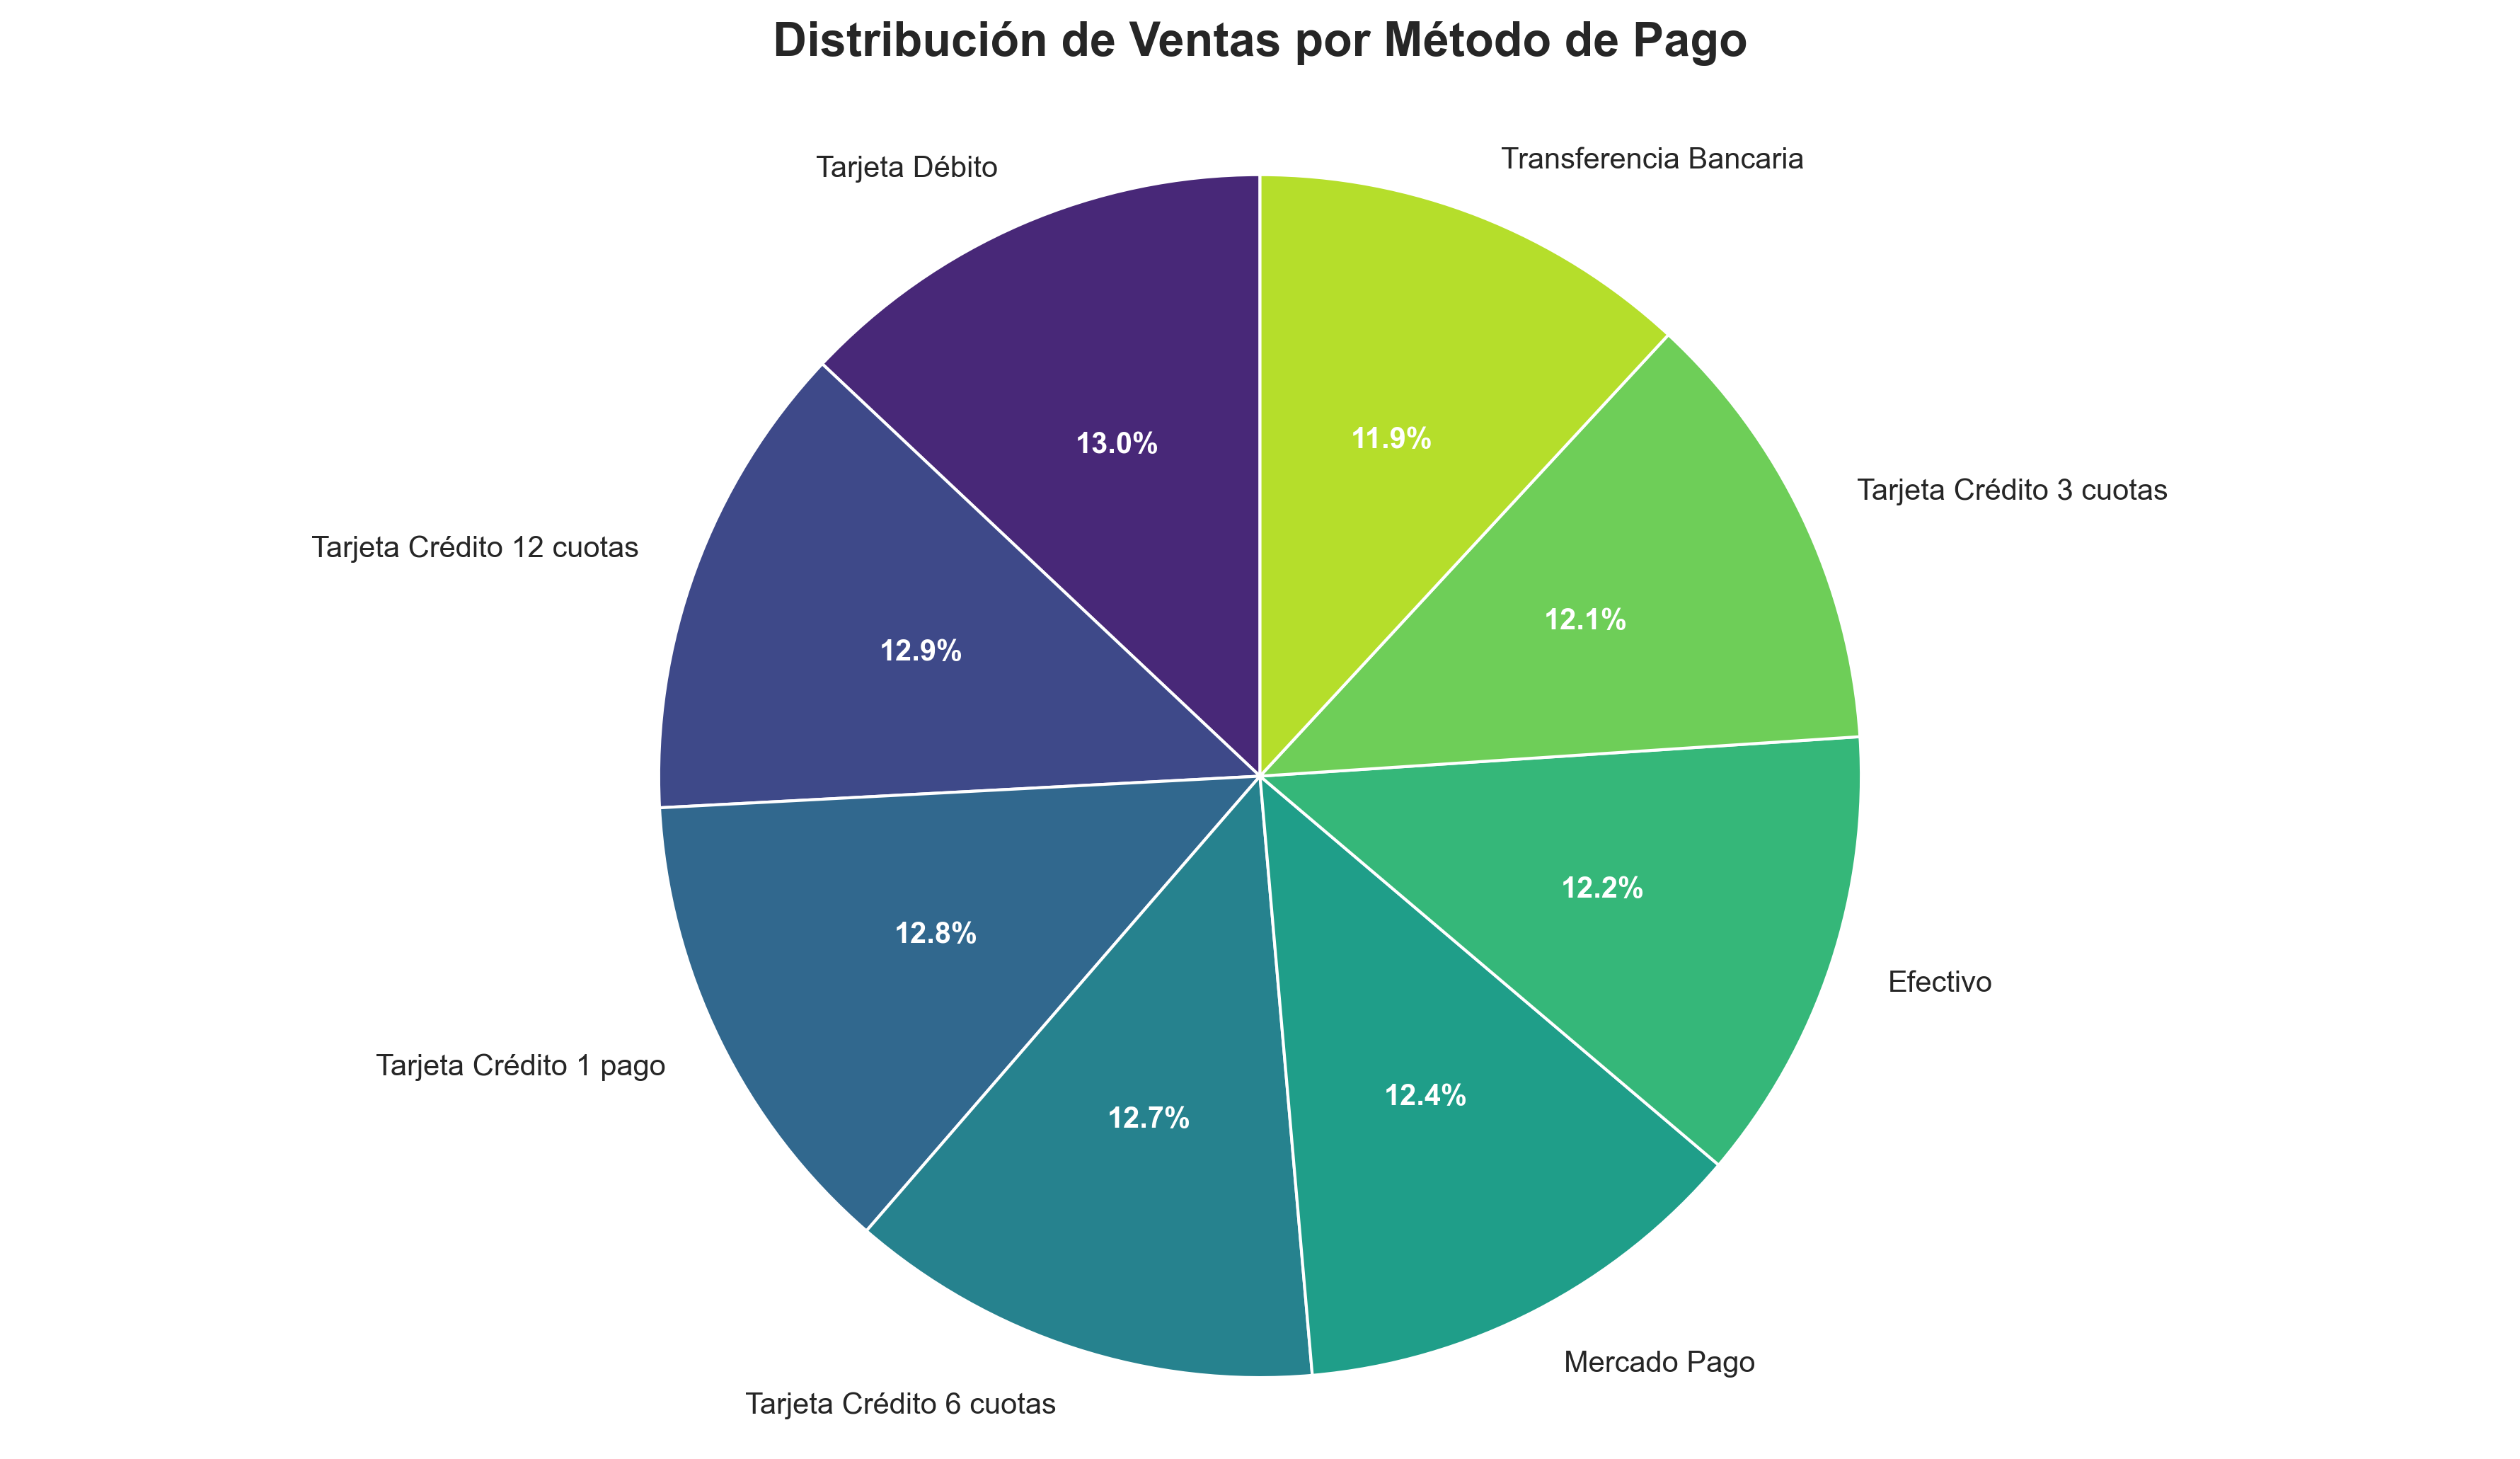

Análisis de ventas para: 'Dame un gráfico sobre la distribución de los medios de pagos en base de las ventas realizadas'

📊 Tipo de gráfico: Torta
📈 Registros analizados: 8

Resumen de datos:
              metodo_pago  total_ventas
           Tarjeta Débito    4148183.93
Tarjeta Crédito 12 cuotas    4109802.44
   Tarjeta Crédito 1 pago    4092394.86
 Tarjeta Crédito 6 cuotas    4073094.22
             Mercado Pago    3970454.07
                 Efectivo    3910246.18
 Tarjeta Crédito 3 cuotas    3857313.14
   Transferencia Bancaria    3798785.09

Gráfico de torta generado con 8 registros. Título: Distribución de Ventas por Método de Pago

✅ Gráfico generado y mostrado arriba.



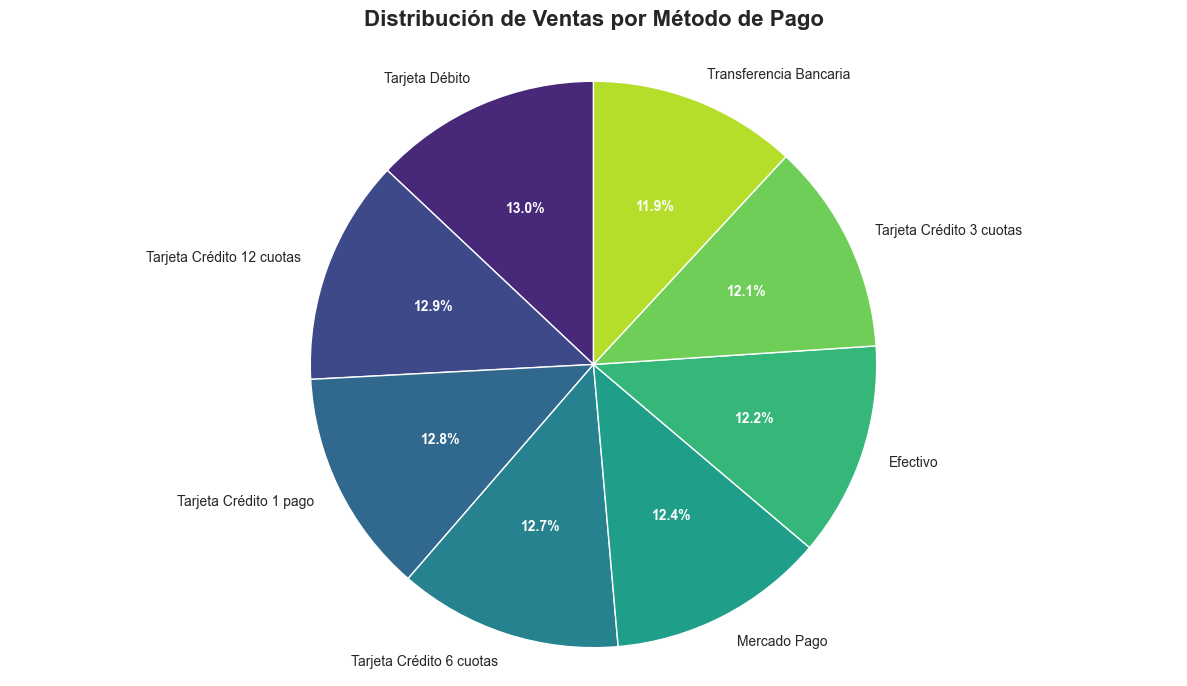

In [75]:
# Prueba 1: Distribución de métodos de pago (gráfico de torta)
print("="*80)
print("PRUEBA 1: Distribución de métodos de pago")
print("="*80)

consulta1 = "Dame un gráfico sobre la distribución de los medios de pagos en base de las ventas realizadas"
resultado1 = analytics_tool.invoke({"query": consulta1})
print(resultado1)


PRUEBA 2: Top 10 productos más vendidos


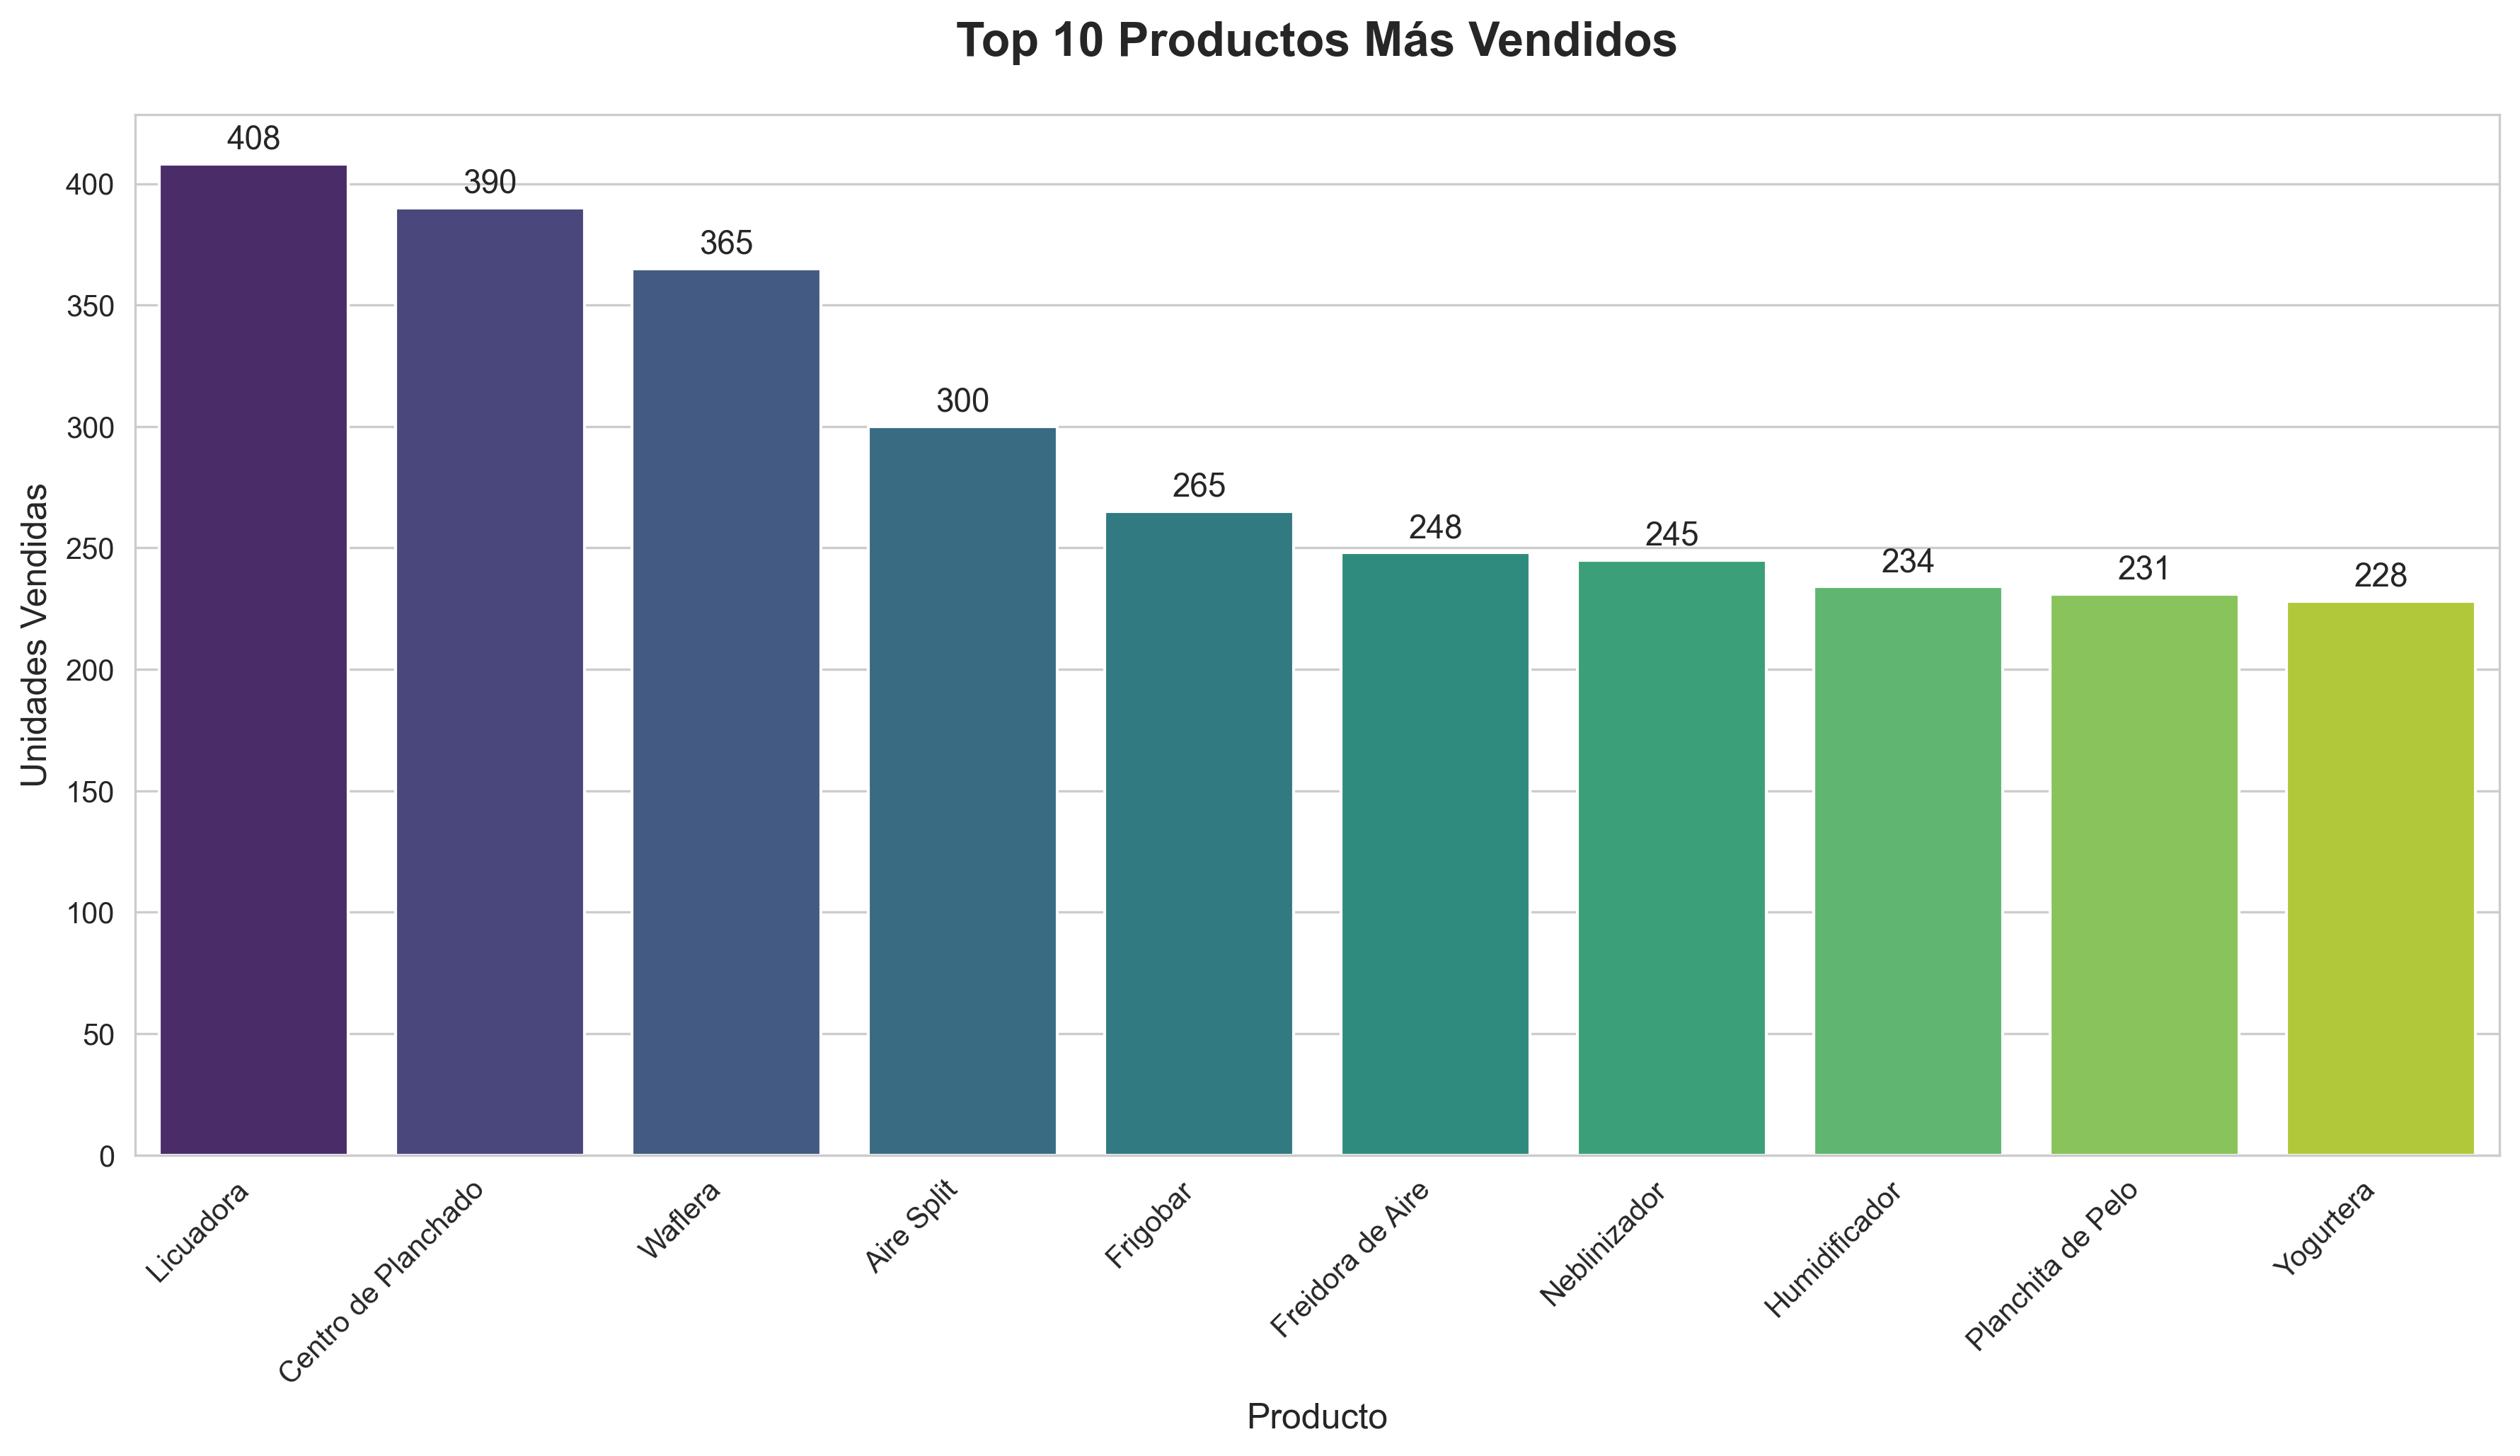

Análisis de ventas para: 'Muéstrame los 10 productos más vendidos en un gráfico de barras'

📊 Tipo de gráfico: Barras
📈 Registros analizados: 10

Resumen de datos:
    nombre_producto  unidades_vendidas
          Licuadora                408
Centro de Planchado                390
            Waflera                365
         Aire Split                300
           Frigobar                265
   Freidora de Aire                248
       Neblinizador                245
      Humidificador                234
  Planchita de Pelo                231
          Yogurtera                228

Gráfico de barras generado con 10 registros. Título: Top 10 Productos Más Vendidos

✅ Gráfico generado y mostrado arriba.



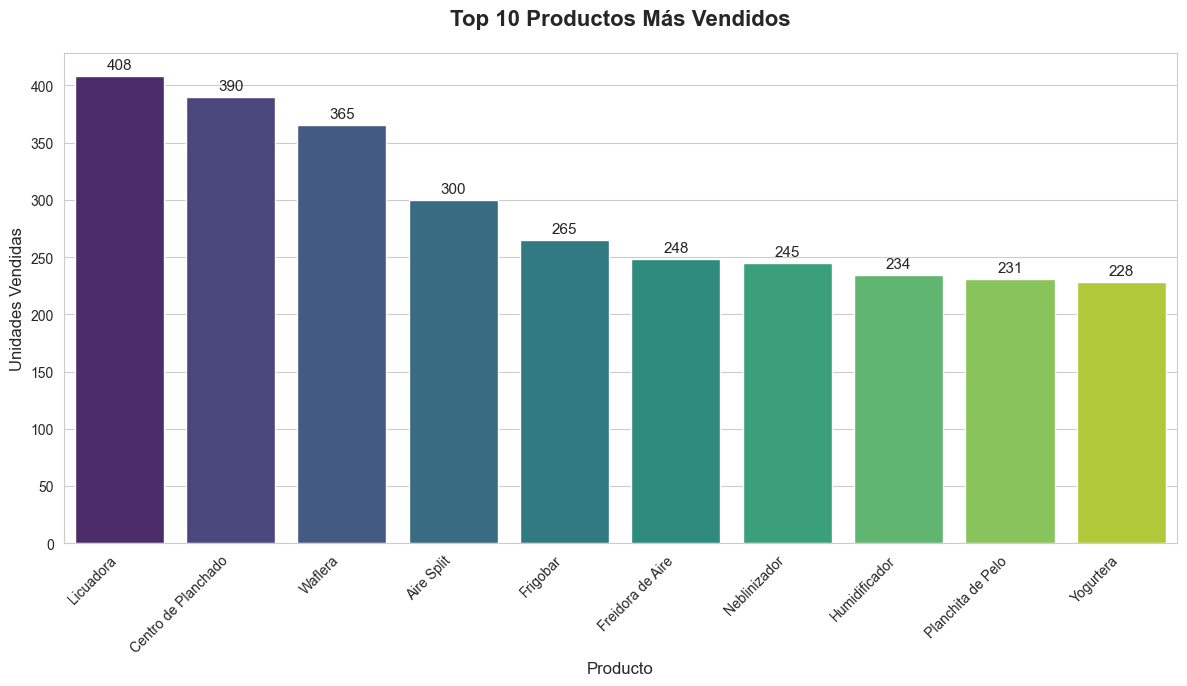

In [76]:
# Prueba 2: Top 10 productos más vendidos (gráfico de barras)
print("\n" + "="*80)
print("PRUEBA 2: Top 10 productos más vendidos")
print("="*80)

consulta2 = "Muéstrame los 10 productos más vendidos en un gráfico de barras"
resultado2 = analytics_tool.invoke({"query": consulta2})
print(resultado2)


PRUEBA 3: Evolución de ventas mensuales


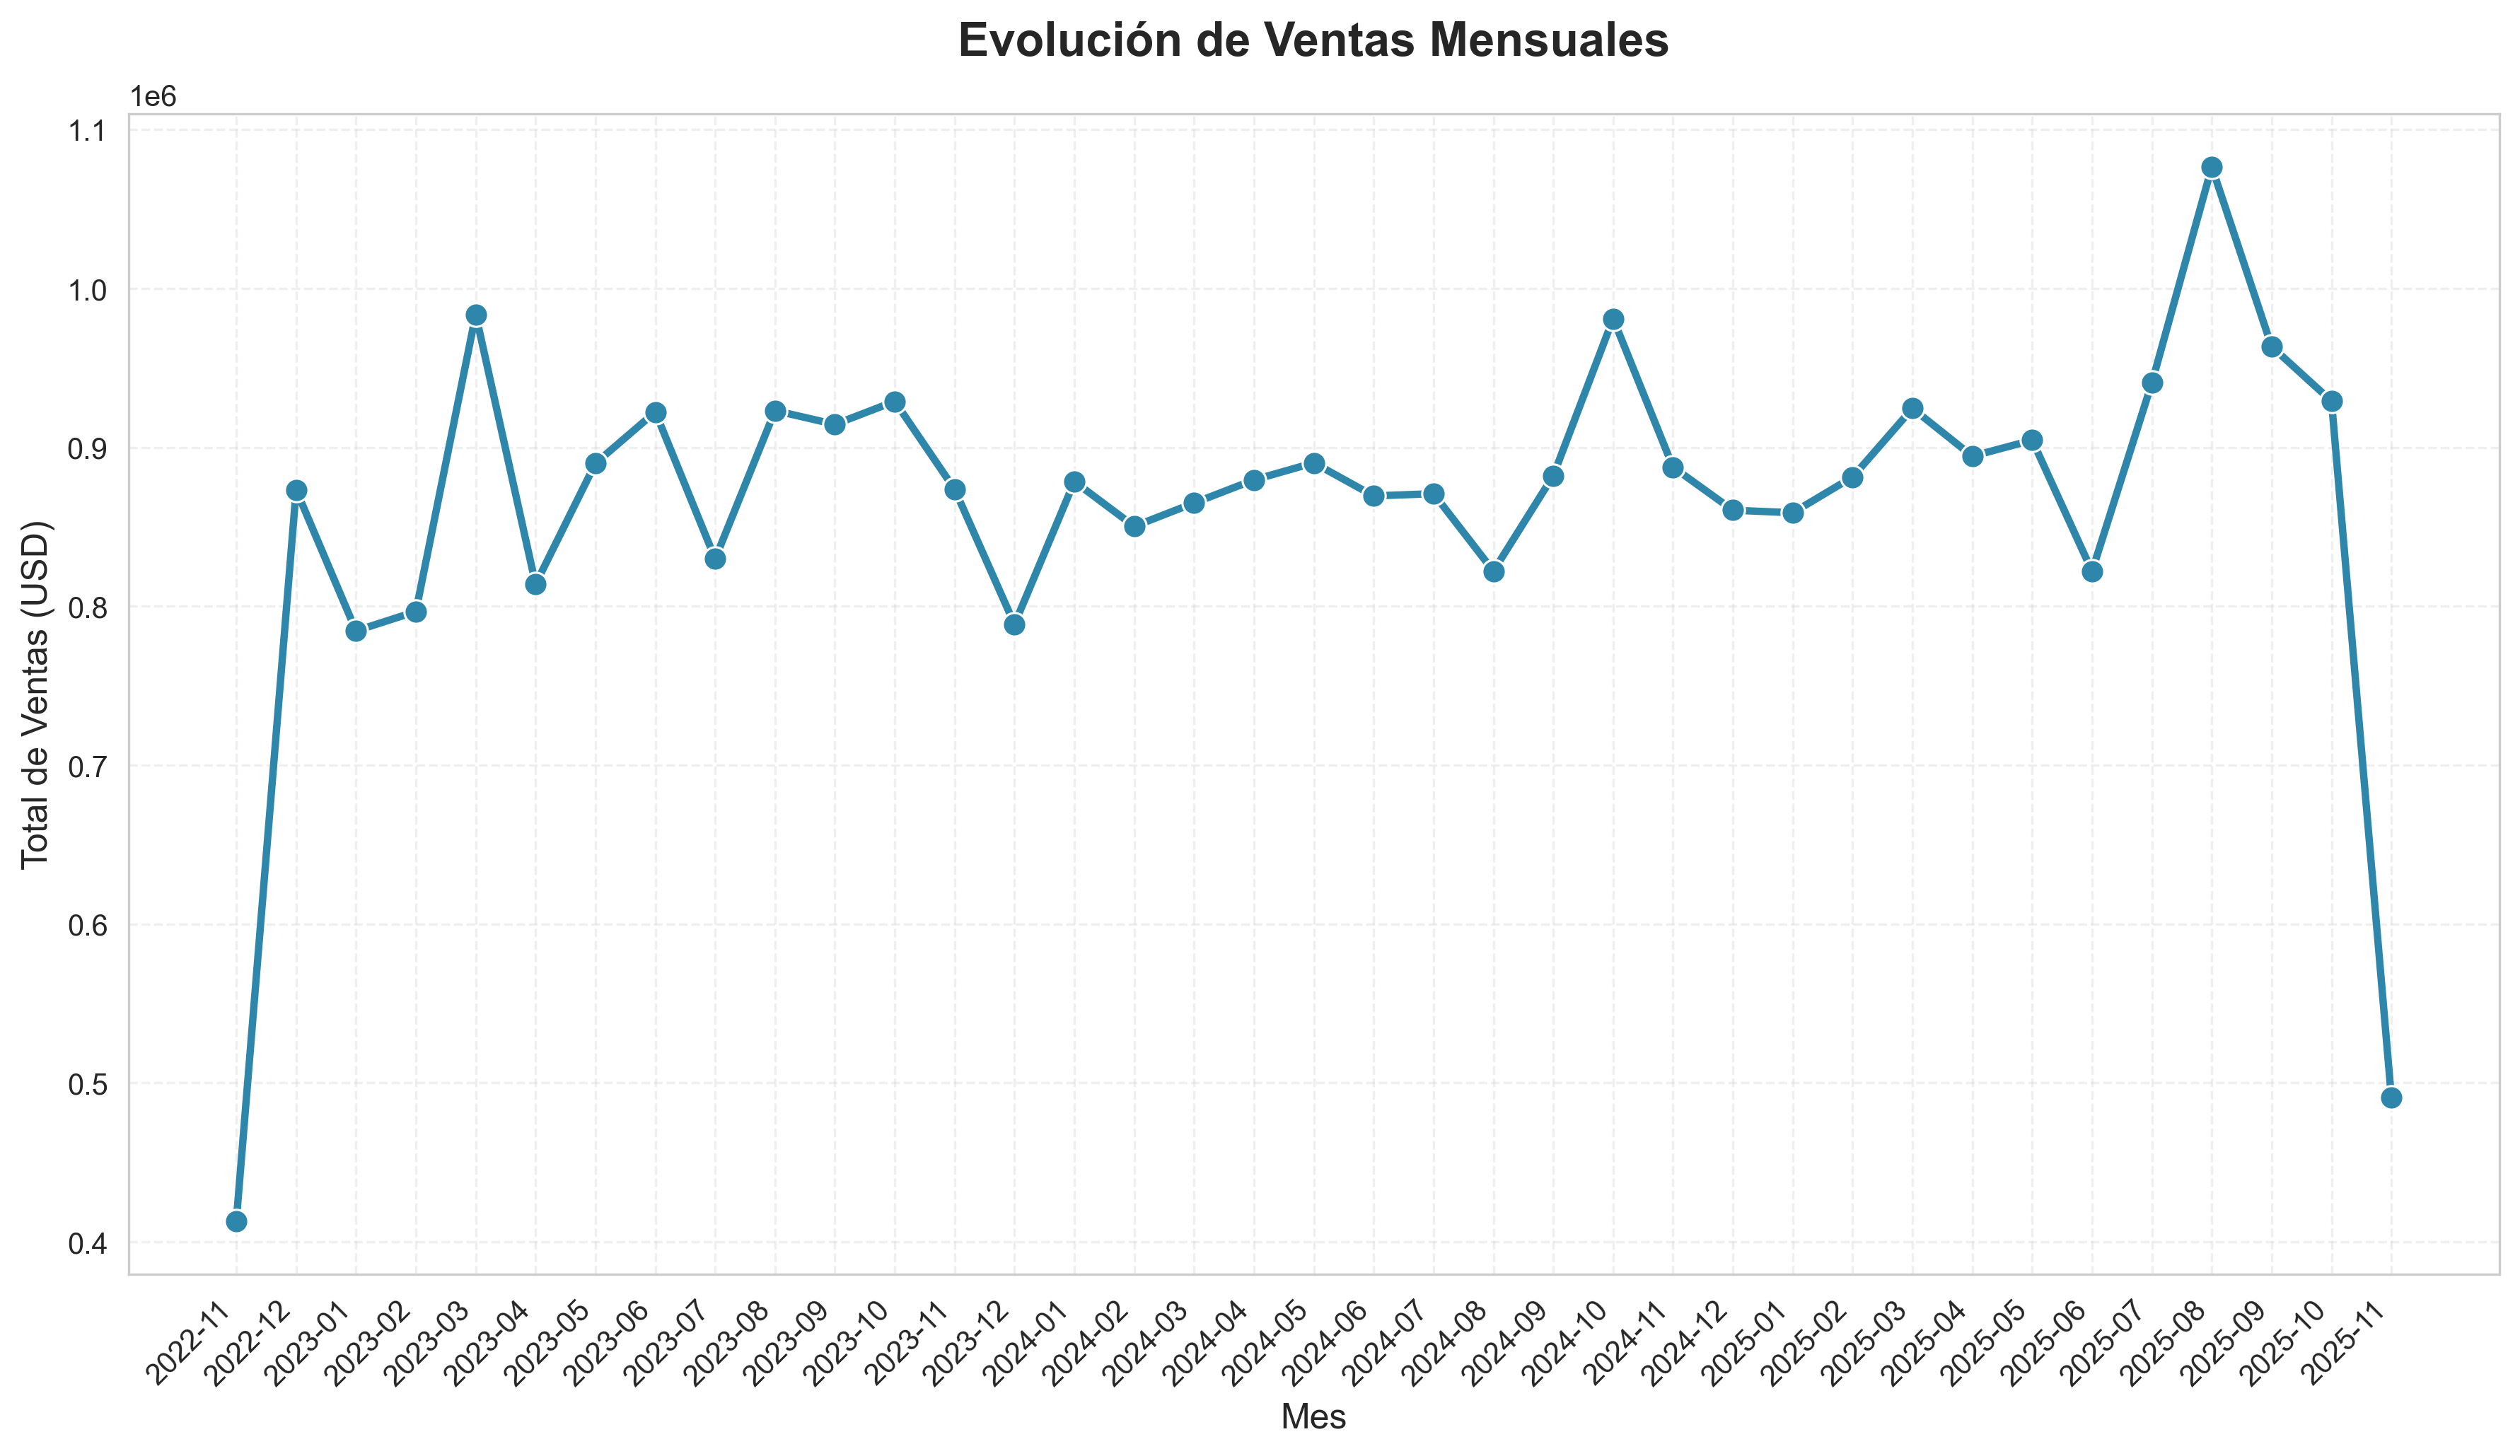

Análisis de ventas para: 'Muéstrame la evolución de las ventas mensuales en un gráfico de líneas'

📊 Tipo de gráfico: Lineas
📈 Registros analizados: 37

Resumen de datos:
    mes  total_ventas
2022-11     412729.52
2022-12     873286.19
2023-01     784549.63
2023-02     796691.74
2023-03     983671.75
2023-04     813911.73
2023-05     890001.30
2023-06     922346.81
2023-07     829868.51
2023-08     923197.07

(Mostrando 10 de 37 registros...)

Gráfico de lineas generado con 37 registros. Título: Evolución de Ventas Mensuales

✅ Gráfico generado y mostrado arriba.



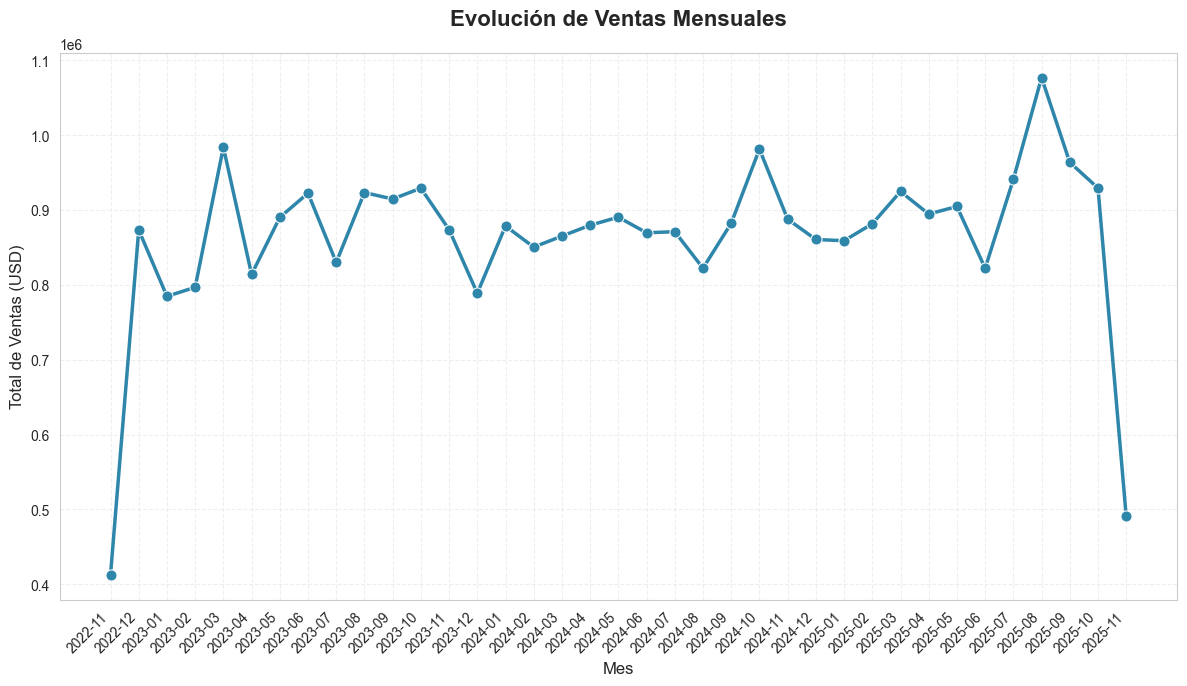

In [77]:
# Prueba 3: Ventas mensuales (gráfico de líneas)
print("\n" + "="*80)
print("PRUEBA 3: Evolución de ventas mensuales")
print("="*80)

consulta3 = "Muéstrame la evolución de las ventas mensuales en un gráfico de líneas"
resultado3 = analytics_tool.invoke({"query": consulta3})
print(resultado3)

## 2. Creación del Agente RAG

Implementación de herramientas (tools) para el agente que combinan las tres fuentes de datos:
- **doc_search**: Búsqueda híbrida en documentos con re-ranking
- **table_search**: Consultas dinámicas en datos tabulares
- **graph_search**: Consultas dinámicas en base de datos de grafos
- **analytics_tool**: Consults dinamicas base de datos SQL y creacion de gráficos

In [78]:
@tool
def doc_search_tool(query: str, filter_tipo: str = None) -> str:
    """
    Busca información en documentos (manuales, FAQs, tickets, reseñas) usando búsqueda híbrida con re-ranking.
    
    Usa esta herramienta cuando necesites:
    - Información de manuales de productos (instalación, uso, mantenimiento)
    - Respuestas a preguntas frecuentes (FAQs)
    - Soluciones de tickets de soporte técnico
    - Opiniones y reseñas de usuarios
    
    Args:
        query: La pregunta o consulta del usuario
        filter_tipo: (Opcional) Tipo de documento: 'manual', 'faq', 'ticket', 'resena'
    
    Returns:
        Texto con los documentos más relevantes encontrados
    """
    try:
        # Llamar a la función de búsqueda híbrida
        results = doc_search(query, n_results=7, filter_tipo=filter_tipo, use_rerank=True)
        
        # Formatear resultados
        if not results['documents']:
            return f"No se encontraron documentos relevantes para: {query}"
        
        response = f"Resultados para '{query}' ({results['method']}):\n\n"
        
        for i, doc in enumerate(results['documents'], 1):
            tipo = doc['metadata'].get('tipo', 'desconocido')
            score = doc['score']
            text = doc['text'][:300]  # Limitar longitud
            
            response += f"{i}. [{tipo.upper()}] (Relevancia: {score:.3f})\n"
            response += f"   {text}...\n\n"
        
        return response
    
    except Exception as e:
        return f"Error al buscar documentos: {str(e)}"


@tool
def table_search_tool(query: str) -> str:
    """
    Realiza consultas sobre el catálogo de productos usando lenguaje natural para consultar un dataframe de pandas.
    
    Usa esta herramienta cuando necesites:
    - Buscar productos por precio, stock, marca, categoría
    - Comparar productos entre sí
    - Obtener listados de productos más baratos/caros
    - Información específica de productos por ID
    - Listar categorías o marcas disponibles
    
    Args:
        query: Consulta en lenguaje natural sobre productos
        
    Returns:
        Información estructurada sobre los productos encontrados
    """
    try:
        # Llamar a la función de consulta tabular
        resultado = consulta_con_llm_tabular(llm, query)
        
        # Si el resultado es un DataFrame, formatearlo
        if isinstance(resultado, pd.DataFrame):
            if resultado.empty:
                return f"No se encontraron productos para la consulta: {query}"
            
            # Limitar a 10 filas para no saturar el contexto
            df_limited = resultado.head(10)
            
            response = f"Resultados para '{query}':\n\n"
            response += f"Total de productos encontrados: {len(resultado)}\n"
            response += f"Mostrando primeros {len(df_limited)} resultados:\n\n"
            response += df_limited.to_string(index=False)
            
            if len(resultado) > 10:
                response += f"\n\n(Hay {len(resultado) - 10} productos más...)"
            
            return response
        
        # Si es otro tipo de resultado (lista, dict, etc.)
        elif isinstance(resultado, (list, dict)):
            return f"Resultados para '{query}':\n{json.dumps(resultado, indent=2, ensure_ascii=False)}"
        
        else:
            return str(resultado)
    
    except Exception as e:
        return f"Error al consultar productos: {str(e)}"


@tool
def graph_search_tool(query: str) -> str:
    """
    Realiza consultas sobre relaciones entre productos en la base de datos de grafos.
    
    Usa esta herramienta cuando necesites:
    - Encontrar productos relacionados por categoría, marca o precio
    - Productos compatibles por voltaje
    - Productos similares o alternativos
    - Relaciones complejas entre productos
    
    Args:
        query: Consulta en lenguaje natural sobre relaciones entre productos
        
    Returns:
        Descripción y datos de las relaciones encontradas
    """
    try:
        # Verificar conexión
        if graph_db is None:
            return "Error: No hay conexión disponible con la base de datos de grafos."
        
        # Obtener el contexto del schema
        schema_ctx = get_schema_context_for_cypher()
        
        # Llamar a la función de consulta de grafos
        descripcion, df_resultados = consulta_grafo(
            llm=llm,
            graph_db=graph_db,
            consulta_usuario=query,
            schema_context=schema_ctx,
            verbose=False
        )
        
        # Formatear respuesta
        response = f"Consulta de grafos: '{query}'\n\n"
        response += f"{descripcion}\n\n"
        
        if not df_resultados.empty:
            # Limitar a 10 resultados
            df_limited = df_resultados.head(10)
            response += f"Detalles ({len(df_limited)} de {len(df_resultados)} resultados):\n\n"
            response += df_limited.to_string(index=False)
            
            if len(df_resultados) > 10:
                response += f"\n\n(Hay {len(df_resultados) - 10} resultados más...)"
        
        return response
    
    except Exception as e:
        return f"Error al consultar base de grafos: {str(e)}"


# Lista de herramientas disponibles para el agente
tools = [doc_search_tool, table_search_tool, graph_search_tool, analytics_tool]


---

### Descripción de las herramientas

**1. doc_search_tool**
- **Propósito**: Búsqueda en documentos de texto (manuales, FAQs, tickets, reseñas)
- **Tecnología**: Búsqueda híbrida (semántica + BM25) con re-ranking
- **Uso**: Preguntas sobre instalación, uso, solución de problemas, opiniones

**2. table_search_tool**
- **Propósito**: Consultas sobre el catálogo de productos
- **Tecnología**: LLM traduce lenguaje natural a funciones Python
- **Uso**: Buscar por precio, stock, marca, comparaciones, listados

**3. graph_search_tool**
- **Propósito**: Consultas sobre relaciones entre productos
- **Tecnología**: LLM traduce lenguaje natural a queries Cypher
- **Uso**: Productos relacionados, similares, compatibles, alternativas

**4. analytics_tool** 
- **Propósito**: Análisis de ventas históricas y generación de gráficos
- **Tecnología**: LLM traduce lenguaje natural a SQL + visualización con Seaborn
- **Uso**: Estadísticas de ventas, distribuciones, tendencias, rankings
- **Gráficos**: Barras, Torta, Líneas (selección automática según consulta)

In [79]:
def get_agent_prompt():
    with open(METADATA_DIR / "agent_system_prompt.txt", "r", encoding="utf-8") as f:
        prompt = f.read()
    return prompt
prompt_agente = get_agent_prompt()

print(f"\nPrompt del agente cargado. Longitud: {len(prompt_agente)} caracteres ~ {len(prompt_agente)//3} tokens")


Prompt del agente cargado. Longitud: 5971 caracteres ~ 1990 tokens


In [80]:
llm_agent = ChatGoogleGenerativeAI(model="gemini-2.5-flash", google_api_key=api_key, temperature=0)

In [81]:
agent = create_agent(
    model=llm_agent,
    tools=tools,
    system_prompt=prompt_agente,
    name="Asistente de Soporte y Análisis de Electrodomésticos"
)


## Pruebas del Agente

Probando las 6 categorías de consultas principales

---
### Prueba de analytics_tool con imagen

Verifica que el agente use correctamente analytics_tool y muestre la imagen generada.

PRUEBA: Analytics Tool - Distribución de ventas por método de pago


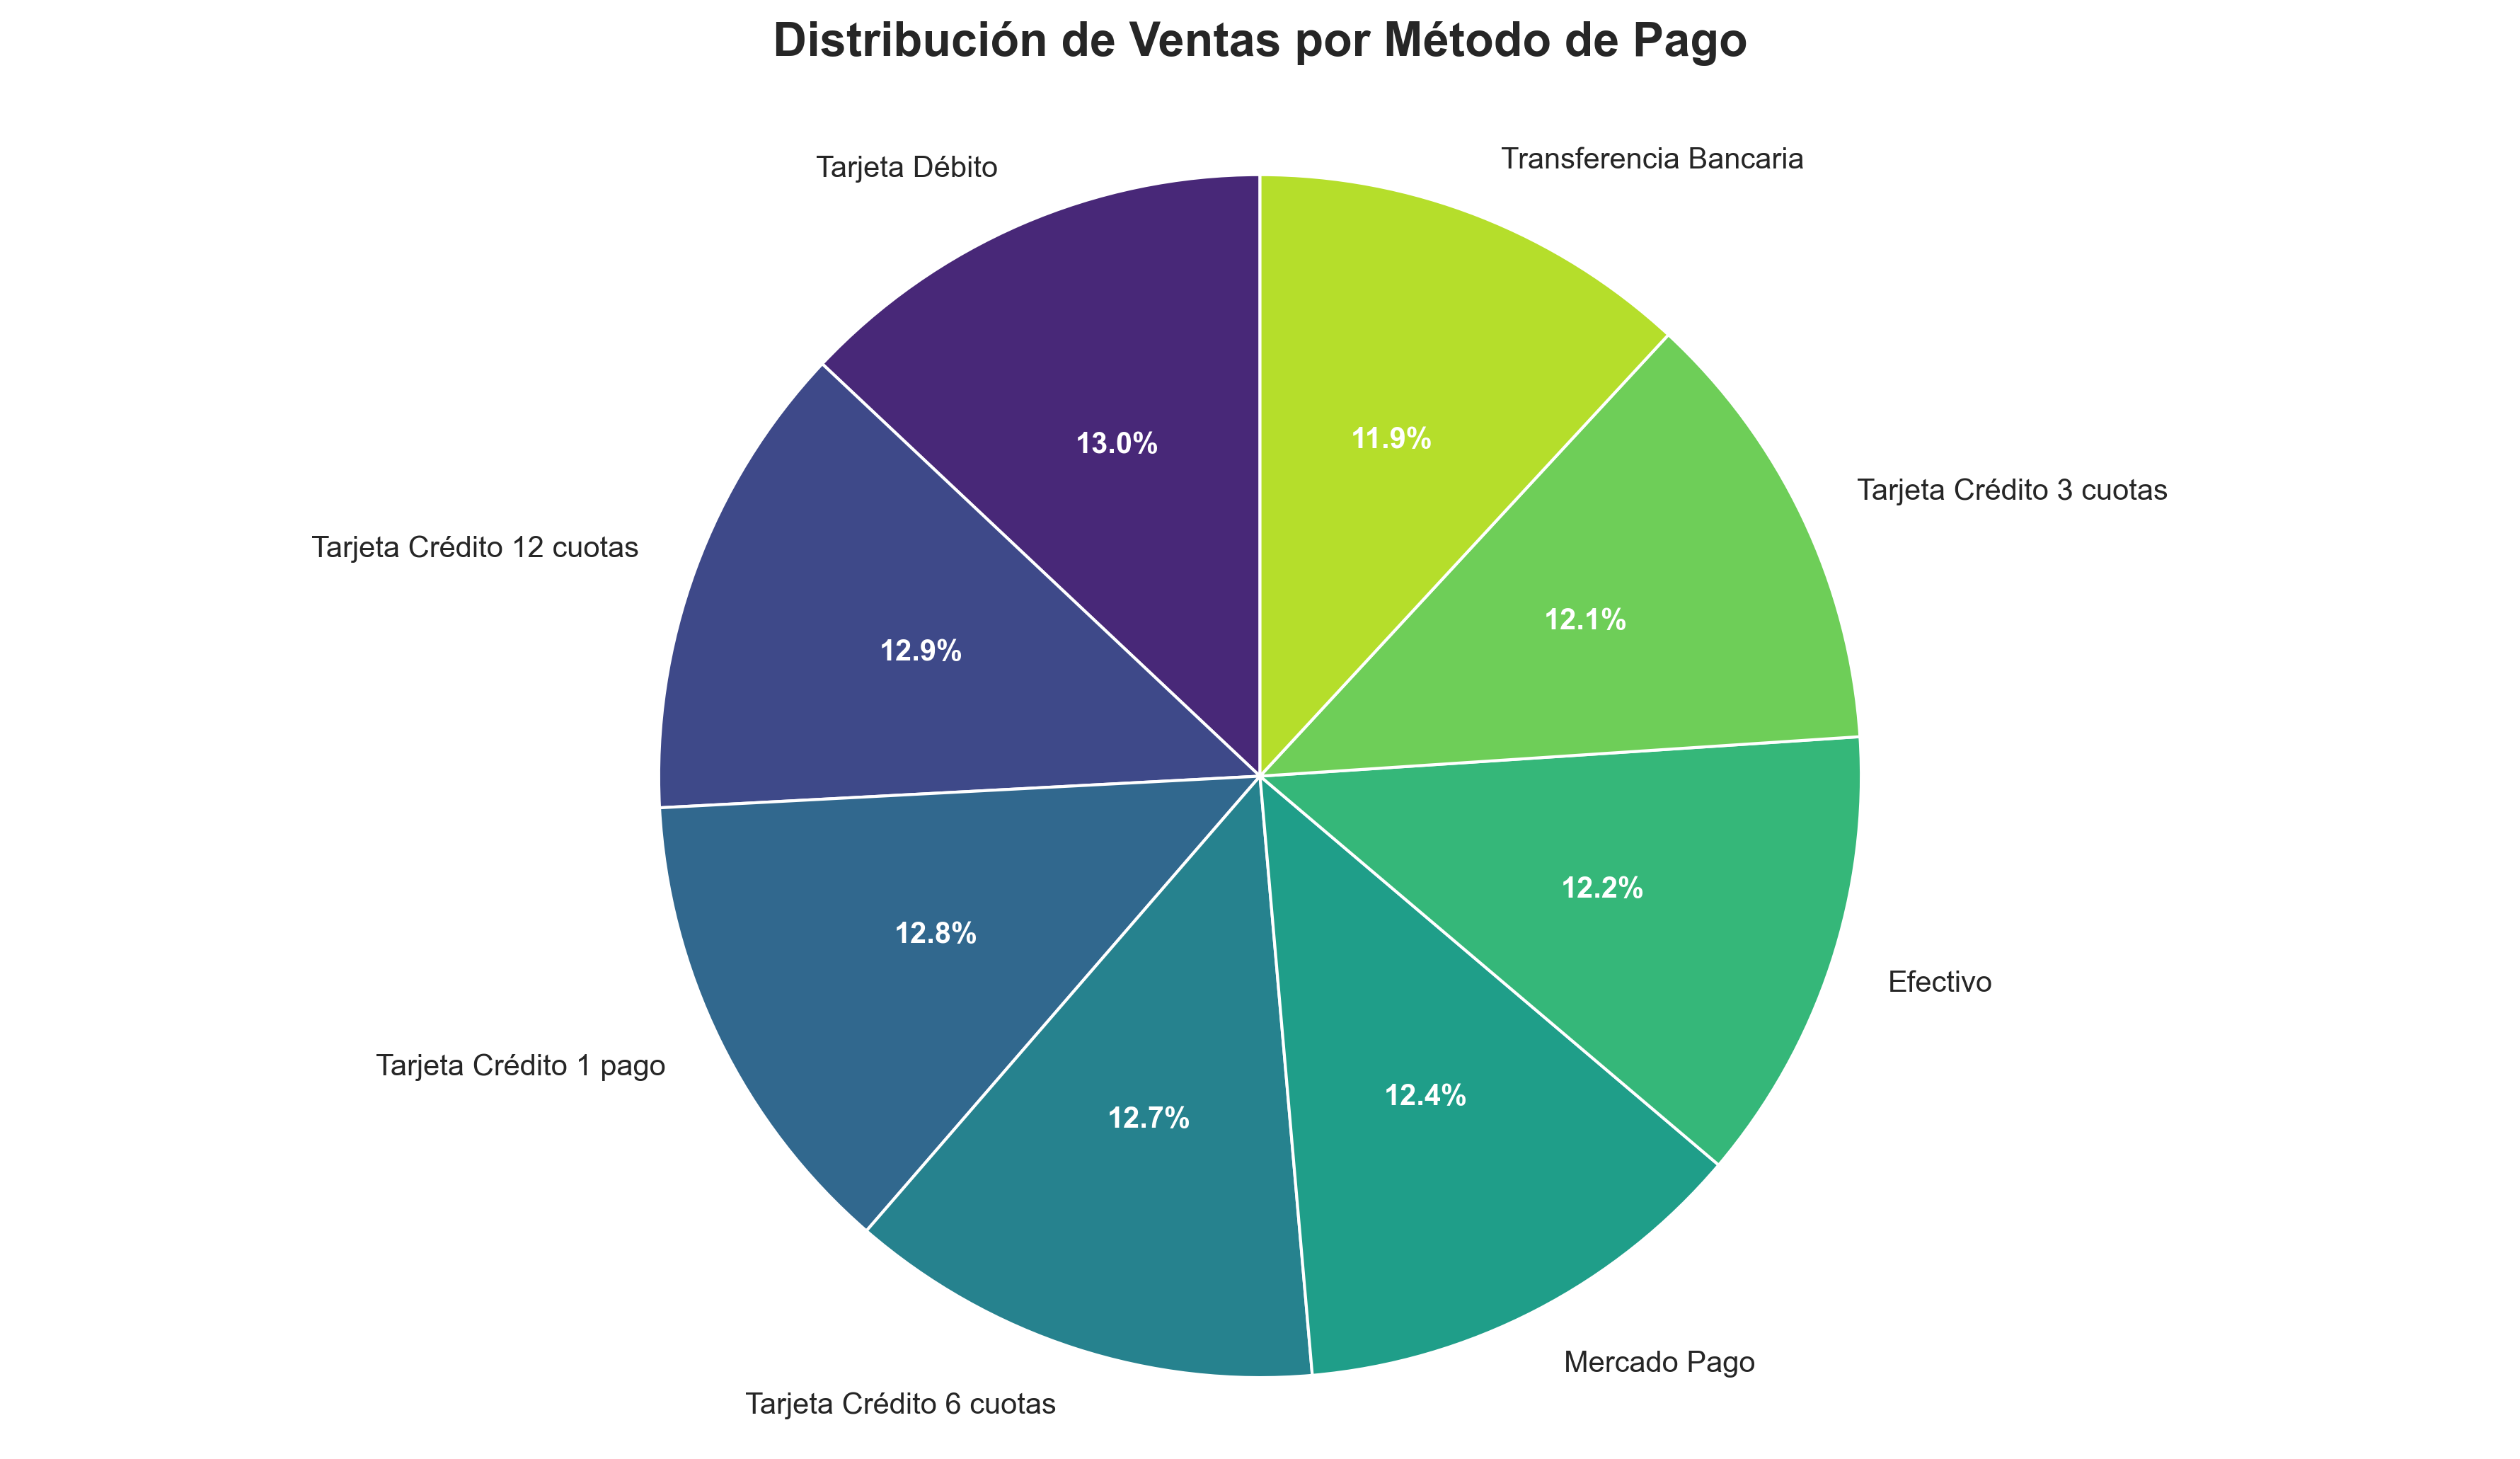

Se ha generado un gráfico de torta que muestra la distribución de ventas por método de pago.

Aquí tienes un resumen de las ventas por cada método de pago:
*   **Tarjeta Débito**: $4,148,183.93
*   **Tarjeta Crédito 12 cuotas**: $4,109,802.44
*   **Tarjeta Crédito 1 pago**: $4,092,394.86
*   **Tarjeta Crédito 6 cuotas**: $4,073,094.22
*   **Mercado Pago**: $3,970,454.07
*   **Efectivo**: $3,910,246.18
*   **Tarjeta Crédito 3 cuotas**: $3,857,313.14
*   **Transferencia Bancaria**: $3,798,785.09

El gráfico ha sido generado y mostrado.


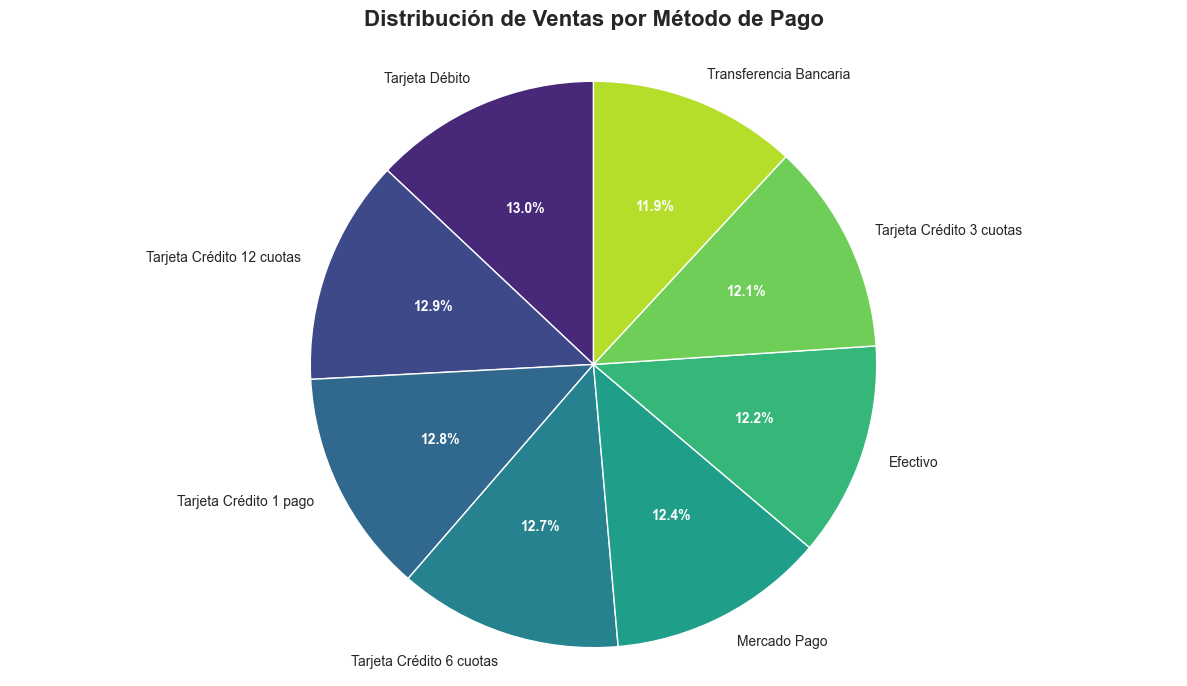

In [82]:
# Prueba: Analytics tool con visualización de imagen
print("="*80)
print("PRUEBA: Analytics Tool - Distribución de ventas por método de pago")
print("="*80)

respuesta = agent.invoke({
    "messages": [{
        "role": "user", 
        "content": "Dame un gráfico de torta con la distribución de ventas por método de pago"
    }]
});

# Extraer contenido de la respuesta
content = respuesta['messages'][-1].content
if isinstance(content, list):
    print(content[0]['text'])
else:
    print(content)

In [51]:
# Pregunta 1: Información sobre usos de productos
print("Pregunta 1: ¿Cómo uso mi licuadora P0004?\n")
respuesta1 = agent.invoke({"messages": [{"role": "user", "content": "Dame los pasos especificos para usar mi licuadora P0004?"}]});
content = respuesta1['messages'][-1].content
if isinstance(content, list):
    print(content[0]['text'])
    print("----------------------------------------")

else:
    print(content)

Pregunta 1: ¿Cómo uso mi licuadora P0004?

He encontrado el manual de usuario para tu licuadora P0004. Aquí te detallo los pasos específicos para su uso:

**Procedimientos de Uso para Licuadora P0004:**

1.  **Ensamblaje:** Asegúrate de que la jarra esté correctamente colocada en la base del motor y que la tapa esté bien cerrada.
2.  **Ingredientes:** Añade los ingredientes a la jarra. No excedas la línea de llenado máximo indicada.
3.  **Conexión:** Enchufa la licuadora a una toma de corriente adecuada (220V).
4.  **Selección de Velocidad:** Gira el dial a la velocidad deseada (Baja, Media, Alta) o utiliza la función de pulso para ráfagas cortas.
5.  **Licuado:** Mantén la licuadora en funcionamiento hasta alcanzar la consistencia deseada.
6.  **Apagado y Desconexión:** Gira el dial a la posición 'OFF' y desenchufa la licuadora antes de retirar la jarra.
7.  **Limpieza:** Desmonta las piezas y lávalas con agua tibia y jabón. La base del motor debe limpiarse únicamente con un paño húme

In [45]:
# Pregunta 2: Información sobre precios de productos
print("Pregunta 2: ¿Cuáles son las licuadoras de menos de $200?\n")
respuesta2 = agent.invoke({"messages": [{"role": "user", "content": "¿Cuáles son las licuadoras de menos de $400?"}]});
content = respuesta2['messages'][-1].content
if isinstance(content, list):
    print(content[0]['text'])
    print("----------------------------------------")

else:
    print(content)

Pregunta 2: ¿Cuáles son las licuadoras de menos de $200?

Aquí tienes las licuadoras disponibles por menos de $400:

*   **Compacto Licuadora (P0004)** de ChefMaster: $259.42 USD
    *   Potencia: 1000W
    *   Capacidad: 2.0L
    *   Voltaje: 220V
    *   Garantía: 24 meses
*   **Licuadora (P0001)** de TechHome: $283.63 USD
    *   Potencia: 650W
    *   Capacidad: 1.2L
    *   Voltaje: 12V
    *   Garantía: 36 meses
*   **Plus Licuadora Pro (P0003)** de TechHome: $329.07 USD
    *   Potencia: 700W
    *   Capacidad: 1.2L
    *   Voltaje: 220V
    *   Garantía: 18 meses

Si necesitas más detalles sobre alguna de ellas o quieres explorar otras opciones, no dudes en preguntar.
----------------------------------------
Aquí tienes las licuadoras disponibles por menos de $400:

*   **Compacto Licuadora (P0004)** de ChefMaster: $259.42 USD
    *   Potencia: 1000W
    *   Capacidad: 2.0L
    *   Voltaje: 220V
    *   Garantía: 24 meses
*   **Licuadora (P0001)** de TechHome: $283.63 USD
    *

In [44]:
# Pregunta 3: Información sobre reseñas de usuarios
print("Pregunta 3: ¿Qué opinan los usuarios de esta cafetera?\n")
respuesta3 = agent.invoke({"messages": [{"role": "user", "content": "¿Qué opinan los usuarios de esta cafetera?"}]});
content = respuesta3['messages'][-1].content
if isinstance(content, list):
    print(content[0]['text'])
    print("----------------------------------------")

else:
    print(content)

Pregunta 3: ¿Qué opinan los usuarios de esta cafetera?

Las opiniones de los usuarios sobre la cafetera (P0122) son bastante variadas:

**Opiniones Negativas:**
*   Algunos usuarios, como Laura_Rojas, Lucas_Rojas y Agustina_Mendoza, expresan una fuerte insatisfacción. Mencionan que "no dura nada, una estafa", que "se calienta y consume mucho", que es "muy voluminoso e inestable" y "ruidoso", e incluso reportaron "problemas con el servicio técnico". Estos usuarios le dieron puntuaciones bajas (1-2/5).

**Opiniones Mixtas:**
*   Otros usuarios, como Facundo_Medina y Gabriel_González, tienen sentimientos encontrados. Indican que la cafetera "tiene sus pros y contras", que "está bien, nada del otro mundo" y que "por el precio está bien, pero no esperen maravillas". Sus puntuaciones fueron promedio (3/5).

**Opiniones Positivas:**
*   Por otro lado, Francisco_Martínez tuvo una experiencia positiva, destacando una "increíble relación calidad-precio", que es "duradero" y "elegante", otorgándo

In [42]:
# Pregunta 4: Recomendación sobre productos
print("Pregunta 4: Quiero una licuadora con buenas reseñas\n")
respuesta4 = agent.invoke({"messages": [{"role": "user", "content": "Quiero una licuadora con buenas reseñas"}]});
content = respuesta4['messages'][-1].content
if isinstance(content, list):
    print(content[0]['text'])
    print("----------------------------------------")
else:
    print(content)

Pregunta 4: Quiero una licuadora con buenas reseñas

Basándome en las reseñas, te puedo recomendar las siguientes licuadoras con buenas puntuaciones (5/5):

*   **Licuadora (P0006) de ChefMaster**: Un usuario quedó "fascinado/a" con este producto, destacando que es "muy versátil, además de práctico" y "preciso".
*   **Licuadora (P0001) de TechHome**: Otro usuario no se arrepiente de la compra, mencionando que es "muy práctico, además de rápido" y "compacto".
----------------------------------------
Basándome en las reseñas, te puedo recomendar las siguientes licuadoras con buenas puntuaciones (5/5):

*   **Licuadora (P0006) de ChefMaster**: Un usuario quedó "fascinado/a" con este producto, destacando que es "muy versátil, además de práctico" y "preciso".
*   **Licuadora (P0001) de TechHome**: Otro usuario no se arrepiente de la compra, mencionando que es "muy práctico, además de rápido" y "compacto".
----------------------------------------


In [39]:
# Pregunta 5: Respuestas a preguntas frecuentes
print("Pregunta 5: ¿Qué voltaje requiere el rallador digital eléctrico?\n")
respuesta5 = agent.invoke({"messages": [{"role": "user", "content": "¿Qué voltaje requiere el rallador digital eléctrico?"}]});
content = respuesta5['messages'][-1].content
if isinstance(content, list):
    print(content[0]['text'])
else:
    print(content)

Pregunta 5: ¿Qué voltaje requiere el rallador digital eléctrico?

No he encontrado un producto llamado "rallador digital eléctrico" en el catálogo. Los resultados de la búsqueda incluyen licuadoras y procesadoras. ¿Te refieres a alguno de estos productos o a otro diferente?
No he encontrado un producto llamado "rallador digital eléctrico" en el catálogo. Los resultados de la búsqueda incluyen licuadoras y procesadoras. ¿Te refieres a alguno de estos productos o a otro diferente?


In [43]:
# Pregunta 6: Respuesta sobre productos relacionados
print("Pregunta 6: ¿Qué productos están relacionados con la categoría Cocina?\n")
respuesta6 = agent.invoke({"messages": [{"role": "user", "content": "¿Qué productos están relacionados con la categoría Cocina?"}]});
content = respuesta6['messages'][-1].content
if isinstance(content, list):
    print(content[0]['text'])
    print("----------------------------------------")

else:
    print(content)

Pregunta 6: ¿Qué productos están relacionados con la categoría Cocina?

Aquí tienes algunos productos relacionados con la categoría Cocina:

*   **P0001** Licuadora - $283.63
*   **P0002** Licuadora - $1273.06
*   **P0003** Plus Licuadora Pro - $329.07
*   **P0004** Compacto Licuadora - $259.42
*   **P0005** Licuadora - $2602.78
*   **P0006** Licuadora - $1837.15
*   **P0007** Licuadora - $2532.47
*   **P0008** Ultra Licuadora - $1201.99
*   **P0009** Procesadora - $1213.21
*   **P0010** Deluxe Procesadora - $1169.67

Hay 10 productos más en esta categoría. Si deseas ver la lista completa o tienes alguna otra pregunta, házmelo saber.
----------------------------------------
Aquí tienes algunos productos relacionados con la categoría Cocina:

*   **P0001** Licuadora - $283.63
*   **P0002** Licuadora - $1273.06
*   **P0003** Plus Licuadora Pro - $329.07
*   **P0004** Compacto Licuadora - $259.42
*   **P0005** Licuadora - $2602.78
*   **P0006** Licuadora - $1837.15
*   **P0007** Licuadora